# Stworzenie SparkSession i importy bibliotek

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql import Window

spark = SparkSession.builder \
    .appName('Mieszkania_data_analysis') \
    .master('local[*]') \
    .getOrCreate()

In [2]:
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType
from pyspark.sql.window import Window
from pyspark.ml import Pipeline

In [3]:
import databricks.koalas as ks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from geopy.geocoders import Nominatim
import os
os.environ['PROJ_LIB'] = r'C:\Users\Administrator\anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap # "pip install --user -U matplotlib==3.2" lub "cartopy" zamiast "basemap"

# Zaczytanie danych z plików do DF

In [5]:
df = spark.read.json("db analiza/*.json")
df.show(2, vertical=True)

-RECORD 0----------------------------------------
 Cena                     | 1 490 000 zł         
 Cena za m2               | 15 360,82 zł/m2      
 Czynsz                   | null                 
 Dostępne od              | null                 
 Długość geograficzna     | 21.0229342           
 Forma własności          | Własność             
 Kategoria                | Mieszkania na spr... 
 Kod pocztowy             | 02-512               
 Kształt działki          | null                 
 Kuchnia                  | jasna z oknem        
 Liczba pięter w budynku  | 4                    
 Liczba pokoi             | 4                    
 Link                     | https://www.domip... 
 Lokalizacja              | Warszawa, Mokotów... 
 Materiał                 | cegła                
 Numer oferty             | BAO-MS-192           
 Piętro                   | 1                    
 Powierzchnia całkowita   | 97 m2                
 Powierzchnia działki     | null                 


Dodanie nazwy województwa (nazwa województwa jest w nazwie pliku)

In [6]:
df = df.withColumn("Województwo", \
                   f.split(f.element_at(f.split(f.element_at(f.split(f.input_file_name(), "/"), -1), "_"), -1), "\.")[0])

In [7]:
df.count()

83392

In [8]:
df.printSchema()

root
 |-- Cena: string (nullable = true)
 |-- Cena za m2: string (nullable = true)
 |-- Czynsz : string (nullable = true)
 |-- Dostępne od: string (nullable = true)
 |-- Długość geograficzna: double (nullable = true)
 |-- Forma własności : string (nullable = true)
 |-- Kategoria: string (nullable = true)
 |-- Kod pocztowy: string (nullable = true)
 |-- Kształt działki : string (nullable = true)
 |-- Kuchnia: string (nullable = true)
 |-- Liczba pięter w budynku : string (nullable = true)
 |-- Liczba pokoi : string (nullable = true)
 |-- Link: string (nullable = true)
 |-- Lokalizacja: string (nullable = true)
 |-- Materiał : string (nullable = true)
 |-- Numer oferty: string (nullable = true)
 |-- Piętro : string (nullable = true)
 |-- Powierzchnia całkowita: string (nullable = true)
 |-- Powierzchnia działki: string (nullable = true)
 |-- Powierzchnia mieszkalna: string (nullable = true)
 |-- Powierzchnia piwnicy: string (nullable = true)
 |-- Rok budowy : string (nullable = true)
 |-

In [9]:
df.distinct().count()

75762

In [10]:
df = df.distinct()

In [11]:
df.show(2, vertical=True)

-RECORD 0----------------------------------------
 Cena                     | 1 840 000 zł         
 Cena za m2               | 15 333,33 zł/m2      
 Czynsz                   | null                 
 Dostępne od              | null                 
 Długość geograficzna     | 21.0257043           
 Forma własności          | własność             
 Kategoria                | Mieszkania na spr... 
 Kod pocztowy             | 02-509               
 Kształt działki          | null                 
 Kuchnia                  | null                 
 Liczba pięter w budynku  | 4                    
 Liczba pokoi             | 4                    
 Link                     | https://www.domip... 
 Lokalizacja              | Warszawa, Mokotów... 
 Materiał                 | inny                 
 Numer oferty             | 8101/1998/OMS        
 Piętro                   | 1                    
 Powierzchnia całkowita   | 120 m2               
 Powierzchnia działki     | null                 


# Preprocessing

##### Potrzebne funkcje

In [12]:
def find_between(s, first, last):
    try:
        start = s.index(first) + len(first)
        end = s.index(last, start)
        return s[start:end]
    except ValueError:
        return ""

def num_filter(a_string):
    try:
        if a_string.find("EUR") == -1:
            if a_string.find(",") == -1:
                return "".join(filter(str.isdigit, a_string))
            else:
                s1 = find_between(a_string, "", ",")
                s2 = find_between(a_string, ",", " ")
                return "".join(filter(str.isdigit, s1)) + "." + s2
        else:
            a_string = a_string[a_string.find("EUR"):]
            if a_string.find(",") == -1:
                return "".join(filter(str.isdigit, a_string))
            else:
                s1 = find_between(a_string, "", ",")
                s2 = find_between(a_string, ",", " ")
                return "".join(filter(str.isdigit, s1)) + "." + s2
    except:
        pass
    
udf_num_filter = f.udf(num_filter, StringType())

##### Zmiana nazw kolumn

In [13]:
df = df.withColumnRenamed('Czynsz ', 'Czynsz')\
.withColumnRenamed('Forma własności ', 'Forma własności')\
.withColumnRenamed('Kształt działki ', 'Kształt działki')\
.withColumnRenamed('Liczba pięter w budynku ', 'Liczba pięter w budynku')\
.withColumnRenamed('Liczba pokoi ', 'Liczba pokoi')\
.withColumnRenamed('Materiał ', 'Materiał')\
.withColumnRenamed('Piętro ', 'Piętro')\
.withColumnRenamed('Rok budowy ', 'Rok budowy')

##### Usuwanie spacji, przecinków itp. z wartości numerycznych

In [14]:
df = df.withColumn('Cena', udf_num_filter(f.col("Cena")))\
.withColumn('Cena za m2', f.regexp_replace('Cena za m2', ' zł/m2', ''))\
.withColumn('Cena za m2', f.regexp_replace('Cena za m2', '\u00a0', ''))\
.withColumn('Cena za m2', f.regexp_replace('Cena za m2', ',', '.'))\
.withColumn('Powierzchnia całkowita', f.regexp_replace('Powierzchnia całkowita', ' m2', ''))\
.withColumn('Powierzchnia całkowita', f.regexp_replace('Powierzchnia całkowita', ',', '.'))\
.withColumn('Powierzchnia mieszkalna', f.regexp_replace('Powierzchnia mieszkalna', ' m2', ''))\
.withColumn('Powierzchnia mieszkalna', f.regexp_replace('Powierzchnia mieszkalna', ',', '.'))\
.withColumn('Powierzchnia działki', f.regexp_replace('Powierzchnia działki', ' m2', ''))\
.withColumn('Powierzchnia działki', f.regexp_replace('Powierzchnia działki', ',', '.'))\
.withColumn('Powierzchnia piwnicy', f.regexp_replace('Powierzchnia piwnicy', ' m2', ''))\
.withColumn('Powierzchnia piwnicy', f.regexp_replace('Powierzchnia piwnicy', ',', '.'))

##### Konwercja typów danych numerycznych (string -> float)

Najpierw zmiana "Parter" na wartość 0, aby przekonwertować do float

In [15]:
df = df.withColumn("Piętro", f.when(df["Piętro"] == "Parter", 0).otherwise(df["Piętro"]))

Konwersja

In [16]:
df = df.withColumn('Cena', df['Cena'].cast(FloatType()))\
.withColumn('Cena za m2', df['Cena za m2'].cast(FloatType()))\
.withColumn('Czynsz', df['Czynsz'].cast(FloatType()))\
.withColumn('Liczba pięter w budynku', df['Liczba pięter w budynku'].cast(IntegerType()))\
.withColumn('Liczba pokoi', df['Liczba pokoi'].cast(IntegerType()))\
.withColumn('Piętro', df['Piętro'].cast(IntegerType()))\
.withColumn('Powierzchnia całkowita', df['Powierzchnia całkowita'].cast(FloatType()))\
.withColumn('Powierzchnia działki', df['Powierzchnia działki'].cast(FloatType()))\
.withColumn('Powierzchnia mieszkalna', df['Powierzchnia mieszkalna'].cast(FloatType()))\
.withColumn('Powierzchnia piwnicy', df['Powierzchnia piwnicy'].cast(FloatType()))\
.withColumn('Rok budowy', df['Rok budowy'].cast(IntegerType()))

# Wstępne oglądanie danych

##### Przygotowanie Koalas DF i Pandas DF na podstawie Spark DF (lepsza wizualizacja)

In [17]:
df.cache()
df_ks = ks.DataFrame(df)
df_pd = df.toPandas()

##### Podgląd rekordów

In [18]:
# df.show(2, vertical=True) # w przypadku spark - gorsza widoczność
df_ks

Cena    Cena za m2  Czynsz   Dostępne od  Długość geograficzna                      Forma własności               Kategoria Kod pocztowy Kształt działki                                                                                          Kuchnia  Liczba pięter w budynku  Liczba pokoi                                                                                                                                               Link                                                                     Lokalizacja      Materiał              Numer oferty  Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy  Rok budowy  Szerokość geograficzna        Typ budynku          Województwo
0    1840000.0  15333.330078     NaN          None             21.025704                             własność  Mieszkania na sprzedaż       02-509            None                                                                                             None                      4.0           4.0                     https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-czteropokojowe-warszawa-mokotow-dominika-merliniego-120m2/152670382                                          Warszawa, Mokotów, Dominika Merliniego          inny             8101/1998/OMS     1.0              120.000000                   NaN                      NaN                   NaN      2017.0               52.195166    apartamentowiec          mazowieckie
1          NaN           NaN     NaN          None             21.002563                                 None  Mieszkania na sprzedaż       02-675            None                                                                                             None                      NaN           2.0                                                                     https://www.domiporta.pl/nowe/ogloszenie/central_house_warszawa-mokotow_607363                                            Warszawa, Mokotów, Domaniewska 47/49         beton                     3.E.2     3.0               44.639999                   NaN                      NaN                   NaN      2022.0               52.183369               None          mazowieckie
2    2100000.0  14583.330078     NaN          None             21.014091                                 None  Mieszkania na sprzedaż       02-625            None                                                                                             None                      8.0           4.0                               https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-czteropokojowe-warszawa-mokotow-woronicza-144m2/152598209                                                 Warszawa, Mokotów, Woronicza 15          None                      None     3.0              144.000000                   NaN                      NaN                   NaN      1999.0               52.188508               blok          mazowieckie
3     740000.0  14509.799805     NaN          None             21.006725                             własność  Mieszkania na sprzedaż       00-110            None                                                                                            aneks                      6.0           2.0                               https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-dwupokojowe-warszawa-mokotow-al-wilanowska-51m2/150341882                                      Warszawa, Mokotów, Henryków, Al.Wilanowska          inny                     22272     2.0               51.000000                   NaN                      NaN                   NaN      2018.0               52.231958    apartamentowiec          mazowieckie
4    2000000.0  17961.380859     NaN          None             21.006725                                 None  Mieszkania na sprzedaż       00-110            None                                                                                             None                      9.0           

##### Schemat

In [19]:
df.printSchema()

root
 |-- Cena: float (nullable = true)
 |-- Cena za m2: float (nullable = true)
 |-- Czynsz: float (nullable = true)
 |-- Dostępne od: string (nullable = true)
 |-- Długość geograficzna: double (nullable = true)
 |-- Forma własności: string (nullable = true)
 |-- Kategoria: string (nullable = true)
 |-- Kod pocztowy: string (nullable = true)
 |-- Kształt działki: string (nullable = true)
 |-- Kuchnia: string (nullable = true)
 |-- Liczba pięter w budynku: integer (nullable = true)
 |-- Liczba pokoi: integer (nullable = true)
 |-- Link: string (nullable = true)
 |-- Lokalizacja: string (nullable = true)
 |-- Materiał: string (nullable = true)
 |-- Numer oferty: string (nullable = true)
 |-- Piętro: integer (nullable = true)
 |-- Powierzchnia całkowita: float (nullable = true)
 |-- Powierzchnia działki: float (nullable = true)
 |-- Powierzchnia mieszkalna: float (nullable = true)
 |-- Powierzchnia piwnicy: float (nullable = true)
 |-- Rok budowy: integer (nullable = true)
 |-- Szerokość

##### Braki danych

Suma braków danych

In [20]:
df.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0------------------------
 Cena                    | 5066  
 Cena za m2              | 5264  
 Czynsz                  | 65785 
 Dostępne od             | 71183 
 Długość geograficzna    | 32    
 Forma własności         | 40813 
 Kategoria               | 25    
 Kod pocztowy            | 1734  
 Kształt działki         | 75612 
 Kuchnia                 | 41688 
 Liczba pięter w budynku | 10696 
 Liczba pokoi            | 736   
 Link                    | 0     
 Lokalizacja             | 25    
 Materiał                | 4696  
 Numer oferty            | 2390  
 Piętro                  | 993   
 Powierzchnia całkowita  | 76    
 Powierzchnia działki    | 75542 
 Powierzchnia mieszkalna | 75039 
 Powierzchnia piwnicy    | 72635 
 Rok budowy              | 12546 
 Szerokość geograficzna  | 32    
 Typ budynku             | 11782 
 Województwo             | 0     



Procentowy udział braków danych

In [21]:
df.select([(f.round(f.count(f.when(f.col(c).isNull(), c)) / f.count(f.lit(1)), 3)).alias(c) for c in df.columns])\
.show(vertical=True)

-RECORD 0------------------------
 Cena                    | 0.067 
 Cena za m2              | 0.069 
 Czynsz                  | 0.868 
 Dostępne od             | 0.94  
 Długość geograficzna    | 0.0   
 Forma własności         | 0.539 
 Kategoria               | 0.0   
 Kod pocztowy            | 0.023 
 Kształt działki         | 0.998 
 Kuchnia                 | 0.55  
 Liczba pięter w budynku | 0.141 
 Liczba pokoi            | 0.01  
 Link                    | 0.0   
 Lokalizacja             | 0.0   
 Materiał                | 0.062 
 Numer oferty            | 0.032 
 Piętro                  | 0.013 
 Powierzchnia całkowita  | 0.001 
 Powierzchnia działki    | 0.997 
 Powierzchnia mieszkalna | 0.99  
 Powierzchnia piwnicy    | 0.959 
 Rok budowy              | 0.166 
 Szerokość geograficzna  | 0.0   
 Typ budynku             | 0.156 
 Województwo             | 0.0   



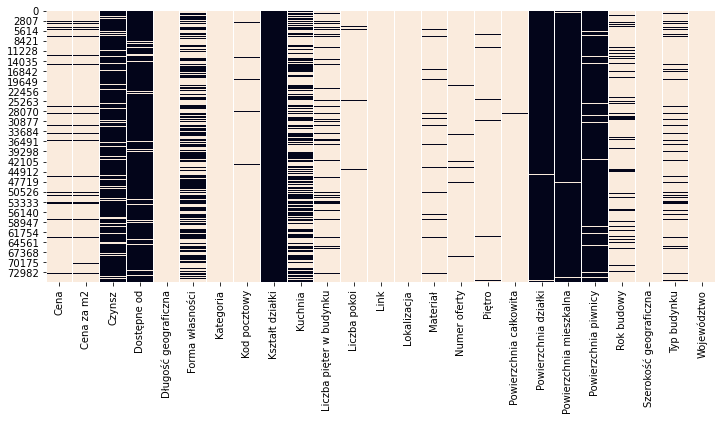

In [22]:
plt.subplots(figsize=(12,5))
sns.heatmap(df_pd.isnull(), cmap='rocket_r', cbar=False)

##### Zmienne numeryczne

In [23]:
# df.describe().show(vertical=True) # w przypadku spark - gorsza widoczność
df_ks.describe()

Cena    Cena za m2       Czynsz  Długość geograficzna  Liczba pięter w budynku   Liczba pokoi        Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy    Rok budowy  Szerokość geograficzna
count  7.069600e+04  7.049800e+04  9977.000000          75730.000000             65066.000000   75026.000000  74769.000000            75686.000000            220.000000               723.000000           3127.000000  6.321600e+04            75730.000000
mean   6.146221e+05  9.543955e+03   427.951689             19.311538                 5.239388       6.614414      2.730691               62.539945            184.265955                60.405560              6.721206  2.545332e+03               51.825606
std    4.120479e+06  5.396971e+04   202.417317              2.000612                 3.908245    1019.682923      7.932758               38.350434            237.153970                25.229697             11.640699  1.135269e+05                1.347426
min    1.000000e+00  1.000000e+00     0.000000              0.688927                 0.000000       0.000000     -1.000000                1.000000              0.000000                10.000000              0.000000 -3.000000e+00                5.883333
25%    3.300000e+05  6.254970e+03   300.000000             17.929884                 3.000000       2.000000      1.000000               44.350000              0.000000                44.300000              3.000000  1.979000e+03               50.883492
50%    4.548840e+05  8.456290e+03   990.000000             19.934831                 4.000000       3.000000      2.000000               56.000000             68.000000                55.990000              4.000000  2.017000e+03               52.173449
75%    6.410080e+05  1.117500e+04   550.000000             20.989716                 6.000000       3.000000      4.000000               71.000000            300.000000                70.750000              7.300000  2.021000e+03               52.319005
max    7.950000e+08  9.034091e+06   990.000000             97.745306                88.000000  279000.000000   2021.000000             5365.590000            972.000000               300.000000            469.000000  2.020202e+07               64.686314

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Administrator\anaconda3\lib\site

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000007225919908>,
      dtype=object)

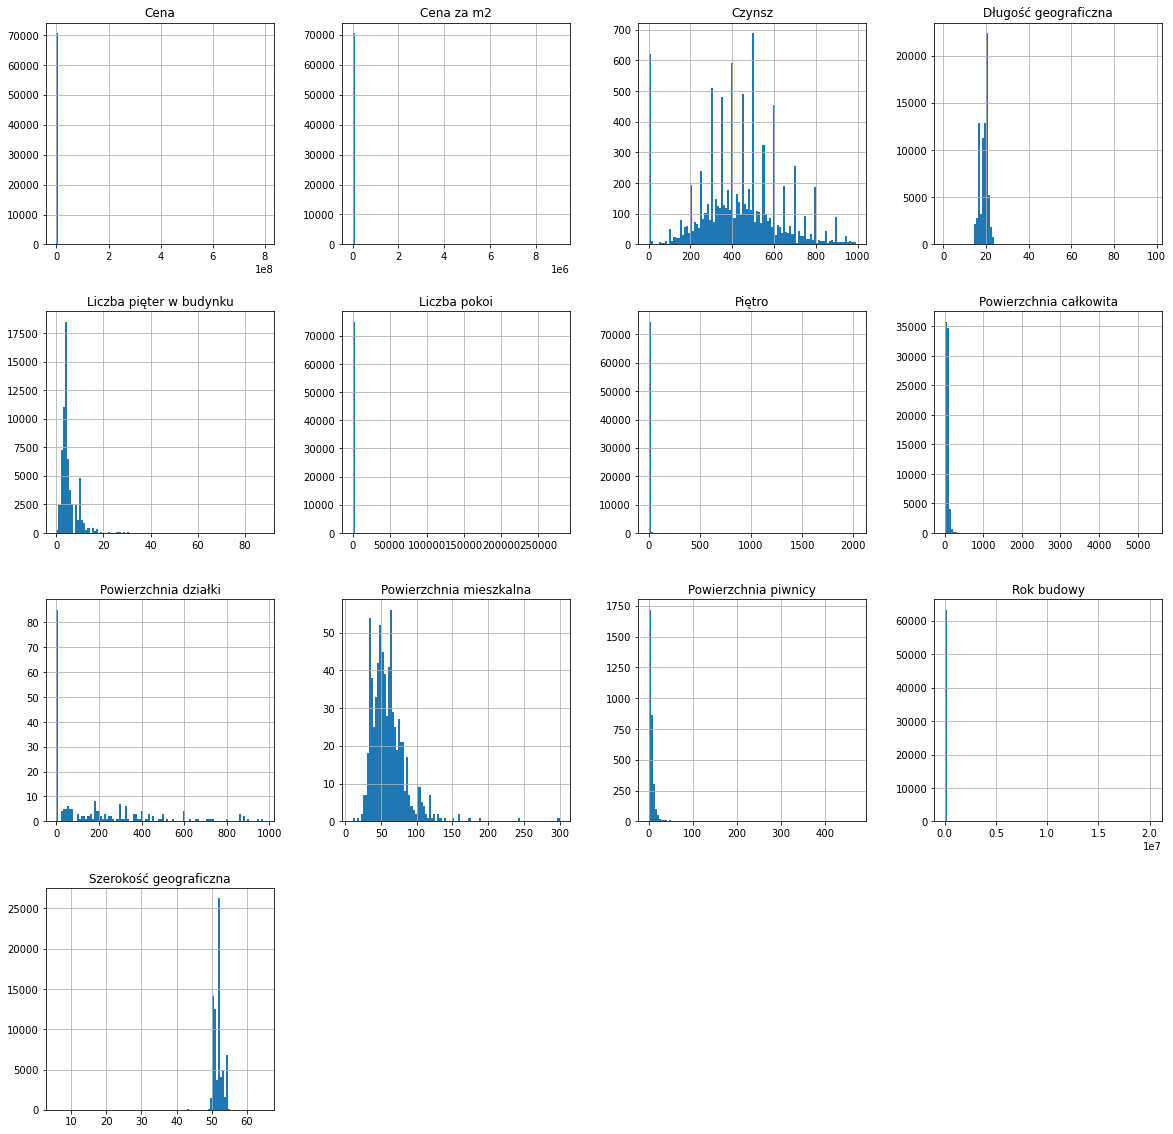

In [24]:
df_pd.hist(bins=100, figsize=(20,20))

##### Zmienne nienumeryczne

In [25]:
df.groupBy("Forma własności").count().orderBy(f.desc("count")).show(truncate=False)
df.select(f.countDistinct("Forma własności")).show()

+-----------------------------------+-----+
|Forma własności                    |count|
+-----------------------------------+-----+
|null                               |40813|
|własność                           |16953|
|Własność                           |8773 |
|spółdzielcze własnościowe          |1610 |
|Odrębna własność lokalu            |1511 |
|spółdzielcze własnościowe z kw     |914  |
|Spółdzielcze własnościowe          |863  |
|własność hipoteczna                |700  |
|PEŁNA WŁASNOŚĆ                     |417  |
|Spółdzielcze wł. z KW              |309  |
|Umowa z developerem                |241  |
|hipoteczne                         |215  |
|Spółdzielcza własnościowa z KW     |210  |
|ODRĘBNA WŁASNOŚĆ                   |197  |
|Spółdzielcza własnościowa bez KW   |167  |
|Odrębna własność                   |153  |
|Spółdzielcze wł. - księga          |150  |
|SPÓŁDZIELCZE WŁASNOŚCIOWE Z KW     |141  |
|spółdzielcze + kw                  |138  |
|odrębna własność z Księgą Wiecz

In [26]:
df.groupBy("Kuchnia").count().orderBy(f.desc("count")).show(truncate=False)
df.select(f.countDistinct("Kuchnia")).show()

+-------------------------------------+-----+
|Kuchnia                              |count|
+-------------------------------------+-----+
|null                                 |41688|
|aneks kuchenny                       |5111 |
|aneks kuchenny - połączony z salonem |4413 |
|oddzielna                            |4121 |
|aneks                                |3605 |
|z oknem                              |2257 |
|otwarta                              |2165 |
|Aneks kuchenny0                      |1678 |
|widna                                |1541 |
|jasna z oknem                        |1281 |
|Kuchnia zamykana z oknem             |594  |
|Kuchnia otwarta z oknem              |531  |
|Jasna, oddzielna0                    |521  |
|zamknięta                            |500  |
|w aneksie                            |432  |
|półotwarta                           |406  |
|osobna                               |333  |
|aneks kuchenny - połączony z jadalnią|322  |
|Jasna0                           

In [27]:
df.groupBy("Materiał").count().orderBy(f.desc("count")).show(truncate=False)
df.select(f.countDistinct("Materiał")).show()

+------------+-----+
|Materiał    |count|
+------------+-----+
|inny        |39380|
|cegła       |16427|
|beton       |4943 |
|null        |4696 |
|wielka płyta|4346 |
|pustak      |3108 |
|rama h      |1186 |
|ytong       |1102 |
|silikat     |557  |
|drewno      |17   |
+------------+-----+

+------------------------+
|count(DISTINCT Materiał)|
+------------------------+
|                       9|
+------------------------+



In [28]:
df.groupBy("Typ budynku").count().orderBy(f.desc("count")).show(truncate=False)
df.select(f.countDistinct("Typ budynku")).show()

+-----------------+-----+
|Typ budynku      |count|
+-----------------+-----+
|blok             |22713|
|inny             |21053|
|apartamentowiec  |13308|
|null             |11782|
|kamienica        |6610 |
|dom wielorodzinny|296  |
+-----------------+-----+

+---------------------------+
|count(DISTINCT Typ budynku)|
+---------------------------+
|                          5|
+---------------------------+



Dodanie kolumny z miejscowością

In [29]:
df = df.withColumn("Miejscowość", f.initcap(f.split("Lokalizacja", ", ")[0]))

In [30]:
df.groupBy("Miejscowość")\
.agg(f.count("Miejscowość").alias("Liczba ogłoszeń"))\
.orderBy("Liczba ogłoszeń", ascending=False)\
.show()

+-------------------+---------------+
|        Miejscowość|Liczba ogłoszeń|
+-------------------+---------------+
|           Warszawa|          21943|
|            Wrocław|           8524|
|             Kraków|           8048|
|             Gdańsk|           3208|
|               Łódź|           2261|
|             Poznań|           2249|
|          Bydgoszcz|           1942|
|            Rzeszów|           1345|
|           Katowice|           1307|
|        Częstochowa|           1091|
|             Lublin|           1072|
|             Kielce|           1018|
|             Gdynia|           1010|
|           Szczecin|            972|
|            Gliwice|            756|
|          Kołobrzeg|            734|
|          Białystok|            559|
|              Opole|            523|
|          Wieliczka|            500|
|Gorzów Wielkopolski|            402|
+-------------------+---------------+
only showing top 20 rows



In [31]:
df.show(1, vertical=True)

-RECORD 0---------------------------------------
 Cena                    | 1840000.0            
 Cena za m2              | 15333.33             
 Czynsz                  | null                 
 Dostępne od             | null                 
 Długość geograficzna    | 21.0257043           
 Forma własności         | własność             
 Kategoria               | Mieszkania na spr... 
 Kod pocztowy            | 02-509               
 Kształt działki         | null                 
 Kuchnia                 | null                 
 Liczba pięter w budynku | 4                    
 Liczba pokoi            | 4                    
 Link                    | https://www.domip... 
 Lokalizacja             | Warszawa, Mokotów... 
 Materiał                | inny                 
 Numer oferty            | 8101/1998/OMS        
 Piętro                  | 1                    
 Powierzchnia całkowita  | 120.0                
 Powierzchnia działki    | null                 
 Powierzchnia mieszk

# Wstępne czyszczenie danych (ręczne usunięcie outlierów)

##### Cena

Ile cen nie jest w przedziale 10k-20m

In [32]:
df.filter((df["Cena"] < 10000) | (df["Cena"] > 20000000)).count()

133

In [33]:
df_ks[(df_ks["Cena"] < 10000) | (df_ks["Cena"] > 20000000)]

Cena    Cena za m2  Czynsz   Dostępne od  Długość geograficzna                   Forma własności               Kategoria Kod pocztowy Kształt działki                               Kuchnia  Liczba pięter w budynku  Liczba pokoi                                                                                                                                Link                                                           Lokalizacja      Materiał     Numer oferty  Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy  Rok budowy  Szerokość geograficzna      Typ budynku         Województwo
122            1.0           NaN     NaN          None             17.062596                              None  Mieszkania na sprzedaż       55-100            None                        aneks kuchenny                      2.0           3.0                                    https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-trzebnica-63m2/152683122                                                             Trzebnica          inny   18665/3265/OMS     2.0               63.349998                   NaN                      NaN                   NaN      2021.0               51.309642  apartamentowiec        dolnoslaskie
123            1.0           NaN     NaN          None             17.062596                              None  Mieszkania na sprzedaż       55-100            None                             oddzielna                      3.0           1.0                                                  https://www.domiporta.pl/nieruchomosci/sprzedam-kawalerke-trzebnica-40m2/152683120                                                             Trzebnica          inny   18663/3265/OMS     1.0               40.009998                   NaN                      NaN                   NaN      2021.0               51.309642  apartamentowiec        dolnoslaskie
912            1.0           NaN     NaN          None             16.134031                              None  Mieszkania na sprzedaż       59-220            None                        aneks kuchenny                      3.0           2.0                             https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-dwupokojowe-legnica-dzialkowa-43m2/152103168                                                    Legnica, Działkowa          inny    4027/6038/OMS     3.0               43.000000                   NaN                      NaN                   NaN         NaN               51.218225             blok        dolnoslaskie
917            1.0           NaN     NaN          None             17.062596                          własność  Mieszkania na sprzedaż       55-100            None                               otwarta                      2.0           2.0                                     https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-dwupokojowe-trzebnica-45m2/152228724                                                             Trzebnica          inny   18422/3265/OMS     0.0               44.689999                   NaN                      NaN                   NaN      2021.0               51.309642  apartamentowiec        dolnoslaskie
918            1.0           NaN     NaN          None             17.062596                          własność  Mieszkania na sprzedaż       55-100            None                               otwarta                      3.0           2.0                                     https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-dwupokojowe-trzebnica-50m2/152208321                                                             Trzebnica          inny   18405/3265/OMS     3.0               50.029999                   NaN                      NaN                   NaN      2021.0               51.309642  apartamentowiec        dolnoslaskie
1737        1200.0  3.300000e+01     NaN  10.04.2021r.             19.936856                              None  Mieszkania na 

##### Cena za m2

Sprawdzenie czy Cena/m2 policzona wg sparka zgadza się z wartością podaną w ogłoszeniu

In [34]:
df.withColumn("Cena za m2 count / Cena za m2", df["Cena"]/df["Powierzchnia całkowita"]/df["Cena za m2"])\
.select("Cena za m2 count / Cena za m2")\
.dropna()\
.orderBy("Cena za m2 count / Cena za m2")\
.show(3)

df.withColumn("Cena za m2 count / Cena za m2", df["Cena"]/df["Powierzchnia całkowita"]/df["Cena za m2"])\
.select("Cena za m2 count / Cena za m2")\
.dropna()\
.orderBy("Cena za m2 count / Cena za m2", ascending=0)\
.show(3)

+-----------------------------+
|Cena za m2 count / Cena za m2|
+-----------------------------+
|           0.9432854843037295|
|           0.9522675001189906|
|           0.9533333333333334|
+-----------------------------+
only showing top 3 rows

+-----------------------------+
|Cena za m2 count / Cena za m2|
+-----------------------------+
|           1.0152505446623092|
|           1.0102748695997066|
|           1.0101010101010102|
+-----------------------------+
only showing top 3 rows



Są małe różnice wynikające z zaokrągleń, wartość podana w ogłoszeniu zostanie zastąpiona wartością wyliczoną (dodatkowo zniknie część braków danych)

Ile cen za m2 nie jest w przedziale 1k-50k

In [35]:
df.filter((df["Cena za m2"] < 1000) | (df["Cena za m2"] > 50000)).count()

127

In [36]:
df_ks[(df_ks["Cena za m2"] < 1000) | (df_ks["Cena za m2"] > 50000)]

Cena    Cena za m2  Czynsz   Dostępne od  Długość geograficzna                   Forma własności               Kategoria Kod pocztowy Kształt działki                                           Kuchnia  Liczba pięter w budynku  Liczba pokoi                                                                                                                                  Link                                                           Lokalizacja      Materiał     Numer oferty  Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy  Rok budowy  Szerokość geograficzna        Typ budynku          Województwo
127        16800.0  6.544600e+02     NaN          None             16.196363                              None  Mieszkania na sprzedaż       58-370            None                                              None                      NaN           1.0                                               https://www.domiporta.pl/nieruchomosci/sprzedam-kawalerke-boguszow-gorce-26m2/152494876                                                        Boguszów-Gorce          inny    7027/3186/OMS     3.0               25.670000                   NaN                      NaN                   NaN         NaN               50.755252               None         dolnoslaskie
1737        1200.0  3.300000e+01     NaN  10.04.2021r.             19.936856                              None  Mieszkania na sprzedaż       31-042            None                                              None                      7.0           1.0                              https://www.domiporta.pl/nieruchomosci/sprzedam-kawalerke-krakow-krowodrza-fieldorfa-nila-36m2/152713686                          Kraków, Krowodrza, Łobzów, Fieldorfa NIla 12         beton             None     3.0               36.000000                   NaN                      NaN                   NaN      2010.0               50.061947    apartamentowiec          malopolskie
1925       39000.0  5.200000e+02     NaN          None             19.459667                              None  Mieszkania na sprzedaż       90-456            None                                              None                      NaN           3.0                          https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-lodz-srodmiescie-lodz-75m2/152435133                                               Łódź, Śródmieście, łódź          None             None     1.0               75.000000                   NaN                      NaN                   NaN         NaN               51.748928          kamienica              lodzkie
2206        2300.0  6.389000e+01   390.0          None             18.579996                              None  Mieszkania na sprzedaż       80-387            None                                              None                      4.0           2.0                       https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-dwupokojowe-gdansk-przymorze-leborska-36m2/152734269                                           Gdańsk, Przymorze, Lęborska          inny           656558     0.0               36.000000                   NaN                      NaN                   NaN      2018.0               54.404858               inny            pomorskie
3001       35000.0  6.881600e+02     NaN          None             16.677192                          Własność  Mieszkania na sprzedaż       78-411            None                                              None                      0.0           3.0   https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-stare-wierzchowo-szczecinek-stare-wierzchowo-51m2/152780671                        Stare Wierzchowo, Szczecinek, Stare Wierzchowo         cegła          MUPU907     0.0               50.860001                   NaN                      NaN                   NaN      1930.0               53.844937               None            pomorskie
3670   399525056.0  8.75

##### Szerokość i długość geograficzna

Ile ogłoszeń wykracza poza długość i szerokość geograficzną Polski (Polska leży w zakresie 49°00'-54°50' szerokości geograficznej północnej i 14°07'-24°09' długości geograficznej wschodniej)

In [37]:
df.filter((df["Szerokość geograficzna"] < 49) | \
          (df["Szerokość geograficzna"] > (54 + 50/60)) | \
          (df["Długość geograficzna"] < (14 + 7/60)) | \
          (df["Długość geograficzna"] > (24 + 9/60))) \
.count()

134

In [38]:
df_ks[(df_ks["Szerokość geograficzna"] < 49) | \
      (df_ks["Szerokość geograficzna"] > (54 + 50/60)) | \
      (df_ks["Długość geograficzna"] < (14 + 7/60)) | \
      (df_ks["Długość geograficzna"] > (24 + 9/60))]

Cena    Cena za m2  Czynsz  Dostępne od  Długość geograficzna                 Forma własności               Kategoria Kod pocztowy Kształt działki                                                    Kuchnia  Liczba pięter w budynku  Liczba pokoi                                                                                                                          Link                                   Lokalizacja      Materiał    Numer oferty  Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy  Rok budowy  Szerokość geograficzna        Typ budynku         Województwo
1894    455000.0   6914.890137     NaN         None             13.141587                            None  Mieszkania na sprzedaż         None            None                                                       None                      1.0             4                                https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-czteropokojowe-marki-66m2/152780716                                         Marki          inny     TOW-MS-1717     0.0               65.800003                   NaN                      NaN                   NaN      2021.0               43.345839               inny         mazowieckie
3303    201000.0   2912.000000     NaN         None             18.123672                            None  Mieszkania na sprzedaż         None            None                                                       None                      1.0             3                                  https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-luban-69m2/150737396                                         Lubań         cegła            None     1.0               69.019997                   NaN                      NaN                   NaN         NaN               26.823447               blok        dolnoslaskie
4585    420000.0   6248.140137     NaN         None             13.141587                        Własność  Mieszkania na sprzedaż         None            None                      aneks kuchenny - połączony z jadalnią                      2.0             4                                https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-czteropokojowe-marki-67m2/152510193                                         Marki        pustak     AMD-MS-4694     0.0               67.220001                   NaN                      NaN                   NaN      2022.0               43.345839    apartamentowiec         mazowieckie
4895    225000.0   1250.000000     NaN         None              9.099972                            None  Mieszkania na sprzedaż         None            None                                                       None                      1.0             4                                https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-czteropokojowe-nowe-180m2/152433667                                          Nowe          inny        MP341318     1.0              180.000000                   NaN                      NaN                   NaN      2008.0               60.500021               inny           pomorskie
4960    440000.0   7787.609863     4.0         None             13.141587                            None  Mieszkania na sprzedaż         None            None                                                       None                      2.0             3                                  https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-marki-56m2/152534967                                         Marki          inny        GP943746     0.0               56.500000                   NaN                      NaN                   NaN      2020.0               43.345839               inny         mazowieckie
4961    435000.0   6692.310059     NaN         None             13.141587                            None  Mieszkania na sprzedaż         None            None                                            

##### Piętra

Czy piętro jest większe niż liczba pięter w budynku

In [39]:
df.filter(df["Piętro"] > df["Liczba pięter w budynku"]).count()

248

In [40]:
df_ks[df_ks["Piętro"] > df_ks["Liczba pięter w budynku"]]

Cena    Cena za m2  Czynsz   Dostępne od  Długość geograficzna                      Forma własności               Kategoria Kod pocztowy Kształt działki                                Kuchnia  Liczba pięter w budynku  Liczba pokoi                                                                                                                                     Link                                                   Lokalizacja      Materiał      Numer oferty  Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy  Rok budowy  Szerokość geograficzna      Typ budynku          Województwo
92     1500000.0  16558.119141     NaN          None             21.023957                             własność  Mieszkania na sprzedaż       03-468            None                                   None                        4             4              https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-czteropokojowe-warszawa-praga-polnoc-jagiellonska-91m2/152689802                          Warszawa, Praga-Północ, Jagiellońska         cegła    37216/2450/OMS       5               90.589996                   NaN                      NaN                   NaN      2001.0               52.260699        kamienica          mazowieckie
490     150880.0   2300.000000     NaN          None             16.658060                             własność  Mieszkania na sprzedaż       58-200            None                                   None                        2             3                            https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-dzierzoniow-wroclawska-66m2/152698644                                       Dzierżoniów, Wrocławska          inny    41518/5239/OMS       3               65.599998                   NaN                      NaN                   NaN      1900.0               50.735518             None         dolnoslaskie
602     765000.0  19520.289062   274.0          None             18.825234                                 None  Mieszkania na sprzedaż       80-680            None                                  Aneks                        2             2                             https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-dwupokojowe-gdansk-ul-nadwislanska-39m2/152005992                                      Gdańsk, ul. Nadwiślańska         beton      53668/MS/MAX       3               39.189999                   NaN                      NaN                   NaN      2020.0               54.343948             inny            pomorskie
844     899000.0  14983.330078     NaN          None             21.014009                                 None  Mieszkania na sprzedaż       00-511            None                                   None                        0             2                   https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-dwupokojowe-warszawa-srodmiescie-nowogrodzka-60m2/152669730                            Warszawa, Śródmieście, Nowogrodzka          inny   HH-MS-102618019       4               60.000000                   NaN                      NaN                   NaN         1.0               52.229157             inny          mazowieckie
1427    329000.0   4910.450195     NaN          None             17.027730                             własność  Mieszkania na sprzedaż       76-200            None                                 osobna                        0             2                                             https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-dwupokojowe-slupsk-67m2/152753930                                                        Słupsk          None             MS738       1               67.000000                   NaN                      NaN                   NaN      2010.0               54.460571             None            pomorskie
1477    471322.0   8249.990234     NaN          None             16.870367                                 None  Miesz

Skrajne piętra

In [41]:
df.groupBy("Piętro").count().orderBy("Piętro").show(),
df.groupBy("Piętro").count().orderBy("Piętro", ascending=False).show()

+------+-----+
|Piętro|count|
+------+-----+
|  null|  993|
|    -1|   17|
|     0|13051|
|     1|16542|
|     2|13124|
|     3|11653|
|     4| 8558|
|     5| 3472|
|     6| 2305|
|     7| 1761|
|     8| 1238|
|     9|  864|
|    10|  921|
|    11|  352|
|    12|  187|
|    13|  132|
|    14|  109|
|    15|   78|
|    16|   69|
|    17|   47|
+------+-----+
only showing top 20 rows

+------+-----+
|Piętro|count|
+------+-----+
|  2021|    1|
|    81|    1|
|    52|    1|
|    50|    2|
|    48|    8|
|    47|    2|
|    46|    1|
|    45|    3|
|    43|    1|
|    41|    1|
|    40|    4|
|    38|    8|
|    37|    1|
|    34|    2|
|    32|    2|
|    31|    3|
|    30|    6|
|    29|   35|
|    28|    8|
|    27|   11|
+------+-----+
only showing top 20 rows



In [42]:
df_ks[df_ks["Piętro"] >= 40].sort_values("Piętro", ascending=False)

Cena    Cena za m2  Czynsz   Dostępne od  Długość geograficzna Forma własności               Kategoria Kod pocztowy Kształt działki          Kuchnia  Liczba pięter w budynku  Liczba pokoi                                                                                                                                 Link                                                   Lokalizacja Materiał     Numer oferty  Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy  Rok budowy  Szerokość geograficzna      Typ budynku         Województwo
37011    395370.0   6900.000000     NaN  31.07.2021r.             16.978196        własność  Mieszkania na sprzedaż       54-140            None            widna                      2.0             3            https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-wroclaw-fabryczna-ok-stablowickiej-57m2/152736923             Wrocław, Fabryczna, Stabłowice, ok. Stabłowickiej     inny            22611    2021               57.299999                   NaN                      NaN                   NaN      2021.0               51.126311             blok        dolnoslaskie
29357   1090000.0  13457.000000     NaN   7.12.2020r.             18.562867            None  Mieszkania na sprzedaż       81-704            None             None                      NaN             3                            https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-sopot-dolny-3-maja-81m2/152313409                                       Sopot, Dolny, 3 MAJA 14    cegła             None      81               81.000000                   NaN                      NaN                   NaN      1905.0               54.442660        kamienica           pomorskie
4721    9700000.0  49820.238281     NaN          None             21.002937            None  Mieszkania na sprzedaż       00-120            None             None                     54.0             4                 https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-czteropokojowe-warszawa-srodmiescie-zlota-195m2/151836285                                  Warszawa, Śródmieście, Złota     inny    3355/3389/OMS      52              194.699997                   NaN                      NaN                   NaN         NaN               52.230920             None         mazowieckie
2090     404109.0   8082.180176     NaN          None             21.127345            None  Mieszkania na sprzedaż       04-464            None  Aneks kuchenny0                      5.0             3                https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-warszawa-rembertow-chelmzynska-50m2/152689203                              Warszawa, Rembertów, Chełmżyńska    cegła           489370      50               50.000000                   NaN                      NaN                   NaN      2022.0               52.256691             blok         mazowieckie
36612    404109.0   8082.180176     NaN          None             21.127345            None  Mieszkania na sprzedaż       04-464            None  Aneks kuchenny0                      5.0             3                https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-trzypokojowe-warszawa-rembertow-chelmzynska-50m2/152752832                              Warszawa, Rembertów, Chełmżyńska    cegła           490561      50               50.000000                   NaN                      NaN                   NaN      2022.0               52.256691             blok         mazowieckie
2522    5245000.0  23105.730469     NaN          None             16.978196        własność  Mieszkania na sprzedaż       54-140            None   aneks kuchenny                     48.0             5                                https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-wroclaw-krzyki-gwiazdzista-227m2/151291663                                  Wrocław, Krzyki, Gwiaździsta     inny  273060/3376/OMS      48        

##### Liczba pokoi

In [43]:
df.groupBy("Liczba pokoi")\
.agg(f.count("Liczba pokoi").alias("Liczba ogłoszeń"), \
     f.round(f.avg("Powierzchnia całkowita"), 3).alias("Średnia powierzchnia")) \
.withColumn("Powierzchnia_per_pokój", f.round(f.col("Średnia powierzchnia")/f.col("Liczba pokoi"), 3))\
.orderBy("Liczba pokoi").show()

+------------+---------------+--------------------+----------------------+
|Liczba pokoi|Liczba ogłoszeń|Średnia powierzchnia|Powierzchnia_per_pokój|
+------------+---------------+--------------------+----------------------+
|        null|              0|              67.034|                  null|
|           0|             46|             131.127|                  null|
|           1|           7110|              30.525|                30.525|
|           2|          25883|              46.387|                23.194|
|           3|          28138|               65.56|                21.853|
|           4|          10885|              91.829|                22.957|
|           5|           2183|             129.013|                25.803|
|           6|            475|              164.11|                27.352|
|           7|            143|             187.326|                26.761|
|           8|             49|             192.954|                24.119|
|           9|           

Liczba ogłoszeń z liczbą pokoi powyżej 10

In [44]:
df.filter(df["Liczba pokoi"] > 10).count()

53

In [45]:
df_ks[df_ks["Liczba pokoi"] > 10]

Cena    Cena za m2  Czynsz Dostępne od  Długość geograficzna            Forma własności               Kategoria Kod pocztowy Kształt działki                                Kuchnia  Liczba pięter w budynku  Liczba pokoi                                                                                                                      Link                                                     Lokalizacja      Materiał       Numer oferty  Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy  Rok budowy  Szerokość geograficzna        Typ budynku         Województwo
1044          NaN           NaN     NaN        None             18.416650                       None  Mieszkania na sprzedaż       84-230            None                                   None                      NaN            13                                                https://www.domiporta.pl/nowe/ogloszenie/osiedle_locus_rumia-janowo_601188                                     Rumia, Janowo, Stoczniowców          None  LOCUS_1_4_4_MK_80     3.0               59.200001                   NaN                      NaN                   NaN      2020.0               54.566252               None           pomorskie
1674     504758.0   9706.879883     NaN        None             20.882899                       None  Mieszkania na sprzedaż       02-495            None                        Aneks kuchenny0                      4.0            52                                  https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-warszawa-ursus-52m2/152752840                                                 Warszawa, Ursus         cegła             490559     2.0               52.000000                   NaN                      NaN                   NaN      2022.0               52.196098               blok         mazowieckie
3684     220608.0   4990.000000     NaN        None             16.346213                       None  Mieszkania na sprzedaż       58-150            None                                   None                      2.0           123                                        https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-strzegom-44m2/152591758                                                        Strzegom          inny        PSS-MS-1401     1.0               44.209999                   NaN                      NaN                   NaN         NaN               50.960107               inny        dolnoslaskie
3826     579000.0   7375.799805     NaN        None             21.027089                       None  Mieszkania na sprzedaż       05-500            None                                   None                      0.0            33                             https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-piaseczno-piaseczno-78m2/152744174                                            Piaseczno, Piaseczno          None            MS10874     0.0               78.500000                   NaN                      NaN                   NaN         0.0               52.074738               None         mazowieckie
6776          NaN           NaN     NaN        None             18.416650                       None  Mieszkania na sprzedaż       84-230            None                                   None                      NaN            15                                                https://www.domiporta.pl/nowe/ogloszenie/osiedle_locus_rumia-janowo_601189                                     Rumia, Janowo, Stoczniowców          None  LOCUS_1_4_4_MK_88     5.0               59.119999                   NaN                      NaN                   NaN      2020.0               54.566252               None           pomorskie
7167    2932500.0   8500.000000     NaN        None             18.947830                       None  Mieszkania na sprzedaż       40-684            None                              oddzielna                      NaN            11                   h

##### Powierzchnia całkowita

Skrajne wartości

In [46]:
df.select("Powierzchnia całkowita").orderBy("Powierzchnia całkowita", ascending=False).show()

df.select("Powierzchnia całkowita").dropna().orderBy("Powierzchnia całkowita").show()

+----------------------+
|Powierzchnia całkowita|
+----------------------+
|               5365.59|
|                 988.0|
|                 972.0|
|                 947.0|
|                 933.0|
|                 894.0|
|                 860.0|
|                 840.0|
|                 810.0|
|                 796.0|
|                 750.0|
|                 700.0|
|                 691.5|
|                 679.4|
|                 650.0|
|                 621.0|
|                615.54|
|                587.07|
|                 571.0|
|                562.74|
+----------------------+
only showing top 20 rows

+----------------------+
|Powierzchnia całkowita|
+----------------------+
|                   1.0|
|                   1.0|
|                   1.0|
|                   3.9|
|                   3.9|
|                   3.9|
|                   3.9|
|                  5.85|
|                  6.41|
|                   7.8|
|                   7.8|
|                   8.8|

Liczba ogłoszeń z powierzchnią poza zakresem 20-200 m2

In [47]:
df.filter((df["Powierzchnia całkowita"] > 200) | (df["Powierzchnia całkowita"] < 20)).count()

1259

##### Rok budowy

Skrajne wartości

In [48]:
df.groupBy("Rok budowy").count().orderBy("Rok budowy").show(),
df.groupBy("Rok budowy").count().orderBy("Rok budowy", ascending=False).show()

+----------+-----+
|Rok budowy|count|
+----------+-----+
|      null|12546|
|        -3|    1|
|        -2|    1|
|         0|  869|
|         1| 3125|
|         2|    5|
|         3|    3|
|         4|    2|
|        20|    3|
|        21|    1|
|        50|    1|
|        67|    1|
|        70|    2|
|        78|    1|
|        80|    2|
|        82|    1|
|        90|    1|
|        96|    1|
|       190|    1|
|       198|    1|
+----------+-----+
only showing top 20 rows

+----------+-----+
|Rok budowy|count|
+----------+-----+
|  20202020|    1|
|  20072014|    1|
|   1974400|    1|
|     22020|    3|
|     20214|    1|
|     20202|    1|
|     20121|    1|
|     20110|    1|
|     20014|    1|
|     20000|    1|
|     19770|    1|
|     19710|    1|
|      3009|    1|
|      2121|    1|
|      2109|    2|
|      2029|    1|
|      2024|  102|
|      2023| 1012|
|      2022| 8727|
|      2021|10960|
+----------+-----+
only showing top 20 rows



Liczba ogłoszeń z rokiem budowy poza zakresem 1900-2024

In [49]:
df.filter((df["Rok budowy"] < 1900) | (df["Rok budowy"] > 2024)).count()

4399

##### Funkcje z podsumowaniem

Usunięcie nulli opcjonalne

In [50]:
def clean_cena(df, low=10000, high=20000000, dropna=False):
    if dropna == True:
        return df.filter((df["Cena"] >= low) & (df["Cena"] <= high))
    elif dropna == False:
        return df.filter(((df["Cena"] >= low) & (df["Cena"] <= high)) | df["Cena"].isNull())

In [51]:
def clean_cena_za_m2(df, low=1000, high=50000, count_price_per_m2=True, dropna=False):
    if count_price_per_m2 == True:
        df = df.withColumn("Cena za m2", df["Cena"]/df["Powierzchnia całkowita"])
    if dropna == True:
        return df.filter((df["Cena za m2"] >= low) & (df["Cena za m2"] <= high))
    elif dropna == False:
        return df.filter(((df["Cena za m2"] >= low) & (df["Cena za m2"] <= high)) | df["Cena za m2"].isNull())

In [52]:
def clean_lat_lon(df, lat_min=49, lat_max=(54 + 50/60), lon_min=(14 + 7/60), lon_max=(24 + 9/60), dropna=False):
    if dropna == True:
        return df.filter((df["Szerokość geograficzna"] >= lat_min) & \
                         (df["Szerokość geograficzna"] <= lat_max) & \
                         (df["Długość geograficzna"] >= lon_min) & \
                         (df["Długość geograficzna"] <= lon_max))
    elif dropna == False:
        return df.filter(((df["Szerokość geograficzna"] >= lat_min) & \
                         (df["Szerokość geograficzna"] <= lat_max) & \
                         (df["Długość geograficzna"] >= lon_min) & \
                         (df["Długość geograficzna"] <= lon_max)) | \
                         df["Szerokość geograficzna"].isNull() | \
                         df["Długość geograficzna"].isNull())

In [53]:
def clean_pietra(df, min=0, max=100, drop_pietro_greater_than_max=True, dropna=False):
    if dropna == True:
        if drop_pietro_greater_than_max == True:
            return df.filter((df["Piętro"] <= df["Liczba pięter w budynku"]) & \
                             (df["Piętro"] >= min) & \
                             (df["Piętro"] <= max))
        elif drop_pietro_greater_than_max == False:
            return df.filter((df["Piętro"] >= min) & \
                             (df["Piętro"] <= max))
    elif dropna == False:
        if drop_pietro_greater_than_max == True:
            return df.filter(((df["Piętro"] <= df["Liczba pięter w budynku"]) & \
                             (df["Piętro"] >= min) & \
                             (df["Piętro"] <= max)) | \
                             df["Piętro"].isNull() | \
                             df["Liczba pięter w budynku"].isNull())
        elif drop_pietro_greater_than_max == False:
            return df.filter(((df["Piętro"] >= min) & \
                             (df["Piętro"] <= max)) | \
                             df["Piętro"].isNull() | \
                             df["Liczba pięter w budynku"].isNull())

In [54]:
def clean_pokoje(df, min=1, max=10, dropna=False):
    if dropna == True:
        return df.filter((df["Liczba pokoi"] >= min) & \
                         (df["Liczba pokoi"] <= max))
    elif dropna == False:
        return df.filter(((df["Liczba pokoi"] >= min) & \
                         (df["Liczba pokoi"] <= max)) | \
                         df["Liczba pokoi"].isNull())

In [55]:
def clean_powierzchnia(df, min=20, max=200, dropna=False):
    if dropna == True:
        return df.filter((df["Powierzchnia całkowita"] >= min) & \
                         (df["Powierzchnia całkowita"] <= max))
    elif dropna == False:
        return df.filter(((df["Powierzchnia całkowita"] >= min) & \
                         (df["Powierzchnia całkowita"] <= max)) | \
                         df["Powierzchnia całkowita"].isNull())

In [56]:
def clean_rok_budowy(df, min=1900, max=2024, dropna=False):
    if dropna == True:
        return df.filter((df["Rok budowy"] >= min) & \
                         (df["Rok budowy"] <= max))
    elif dropna == False:
        return df.filter(((df["Rok budowy"] >= min) & \
                         (df["Rok budowy"] <= max)) | \
                         df["Rok budowy"].isNull())

##### Usunięcie outlierów

In [57]:
df.count()

75762

In [58]:
df = clean_cena(df)
df = clean_cena_za_m2(df)
df = clean_lat_lon(df)
df = clean_pietra(df)
df = clean_pokoje(df)
df = clean_powierzchnia(df)
df = clean_rok_budowy(df)

In [59]:
df.count()

69613

# Oglądanie danych po wstępnym czyszczeniu

##### Przygotowanie Koalas DF i Pandas DF na podstawie Spark DF (lepsza wizualizacja)

In [60]:
df.cache()
df_ks = ks.DataFrame(df)
df_pd = df.toPandas()

##### Podgląd rekordów

In [61]:
# df.show(2, vertical=True) # w przypadku spark - gorsza widoczność
df_ks

Cena    Cena za m2  Czynsz   Dostępne od  Długość geograficzna                      Forma własności               Kategoria Kod pocztowy Kształt działki                                                                                          Kuchnia  Liczba pięter w budynku  Liczba pokoi                                                                                                                                               Link                                                                     Lokalizacja      Materiał              Numer oferty  Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy  Rok budowy  Szerokość geograficzna        Typ budynku          Województwo           Miejscowość
0    1840000.0  15333.333333     NaN          None             21.025704                             własność  Mieszkania na sprzedaż       02-509            None                                                                                             None                      4.0           4.0                     https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-czteropokojowe-warszawa-mokotow-dominika-merliniego-120m2/152670382                                          Warszawa, Mokotów, Dominika Merliniego          inny             8101/1998/OMS     1.0              120.000000                   NaN                      NaN                   NaN      2017.0               52.195166    apartamentowiec          mazowieckie              Warszawa
1          NaN           NaN     NaN          None             21.002563                                 None  Mieszkania na sprzedaż       02-675            None                                                                                             None                      NaN           2.0                                                                     https://www.domiporta.pl/nowe/ogloszenie/central_house_warszawa-mokotow_607363                                            Warszawa, Mokotów, Domaniewska 47/49         beton                     3.E.2     3.0               44.639999                   NaN                      NaN                   NaN      2022.0               52.183369               None          mazowieckie              Warszawa
2    2100000.0  14583.333333     NaN          None             21.014091                                 None  Mieszkania na sprzedaż       02-625            None                                                                                             None                      8.0           4.0                               https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-czteropokojowe-warszawa-mokotow-woronicza-144m2/152598209                                                 Warszawa, Mokotów, Woronicza 15          None                      None     3.0              144.000000                   NaN                      NaN                   NaN      1999.0               52.188508               blok          mazowieckie              Warszawa
3     740000.0  14509.803922     NaN          None             21.006725                             własność  Mieszkania na sprzedaż       00-110            None                                                                                            aneks                      6.0           2.0                               https://www.domiporta.pl/nieruchomosci/sprzedam-mieszkanie-dwupokojowe-warszawa-mokotow-al-wilanowska-51m2/150341882                                      Warszawa, Mokotów, Henryków, Al.Wilanowska          inny                     22272     2.0               51.000000                   NaN                      NaN                   NaN      2018.0               52.231958    apartamentowiec          mazowieckie              Warszawa
4    2000000.0  17961.383273     NaN          None             21.006725                                 None  Mieszkania na sprzedaż       00-110            None                       

##### Schemat

In [62]:
df.printSchema()

root
 |-- Cena: float (nullable = true)
 |-- Cena za m2: double (nullable = true)
 |-- Czynsz: float (nullable = true)
 |-- Dostępne od: string (nullable = true)
 |-- Długość geograficzna: double (nullable = true)
 |-- Forma własności: string (nullable = true)
 |-- Kategoria: string (nullable = true)
 |-- Kod pocztowy: string (nullable = true)
 |-- Kształt działki: string (nullable = true)
 |-- Kuchnia: string (nullable = true)
 |-- Liczba pięter w budynku: integer (nullable = true)
 |-- Liczba pokoi: integer (nullable = true)
 |-- Link: string (nullable = true)
 |-- Lokalizacja: string (nullable = true)
 |-- Materiał: string (nullable = true)
 |-- Numer oferty: string (nullable = true)
 |-- Piętro: integer (nullable = true)
 |-- Powierzchnia całkowita: float (nullable = true)
 |-- Powierzchnia działki: float (nullable = true)
 |-- Powierzchnia mieszkalna: float (nullable = true)
 |-- Powierzchnia piwnicy: float (nullable = true)
 |-- Rok budowy: integer (nullable = true)
 |-- Szerokoś

##### Braki danych

Suma braków danych

In [63]:
df.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0------------------------
 Cena                    | 4926  
 Cena za m2              | 4957  
 Czynsz                  | 60472 
 Dostępne od             | 65111 
 Długość geograficzna    | 32    
 Forma własności         | 36061 
 Kategoria               | 25    
 Kod pocztowy            | 1496  
 Kształt działki         | 69468 
 Kuchnia                 | 36766 
 Liczba pięter w budynku | 9782  
 Liczba pokoi            | 706   
 Link                    | 0     
 Lokalizacja             | 25    
 Materiał                | 4493  
 Numer oferty            | 2330  
 Piętro                  | 867   
 Powierzchnia całkowita  | 65    
 Powierzchnia działki    | 69430 
 Powierzchnia mieszkalna | 68905 
 Powierzchnia piwnicy    | 66544 
 Rok budowy              | 12181 
 Szerokość geograficzna  | 32    
 Typ budynku             | 10875 
 Województwo             | 0     
 Miejscowość             | 25    



Procentowy udział braków danych

In [64]:
df.select([(f.round(f.count(f.when(f.col(c).isNull(), c)) / f.count(f.lit(1)), 3)).alias(c) for c in df.columns])\
.show(vertical=True)

-RECORD 0------------------------
 Cena                    | 0.071 
 Cena za m2              | 0.071 
 Czynsz                  | 0.869 
 Dostępne od             | 0.935 
 Długość geograficzna    | 0.0   
 Forma własności         | 0.518 
 Kategoria               | 0.0   
 Kod pocztowy            | 0.021 
 Kształt działki         | 0.998 
 Kuchnia                 | 0.528 
 Liczba pięter w budynku | 0.141 
 Liczba pokoi            | 0.01  
 Link                    | 0.0   
 Lokalizacja             | 0.0   
 Materiał                | 0.065 
 Numer oferty            | 0.033 
 Piętro                  | 0.012 
 Powierzchnia całkowita  | 0.001 
 Powierzchnia działki    | 0.997 
 Powierzchnia mieszkalna | 0.99  
 Powierzchnia piwnicy    | 0.956 
 Rok budowy              | 0.175 
 Szerokość geograficzna  | 0.0   
 Typ budynku             | 0.156 
 Województwo             | 0.0   
 Miejscowość             | 0.0   



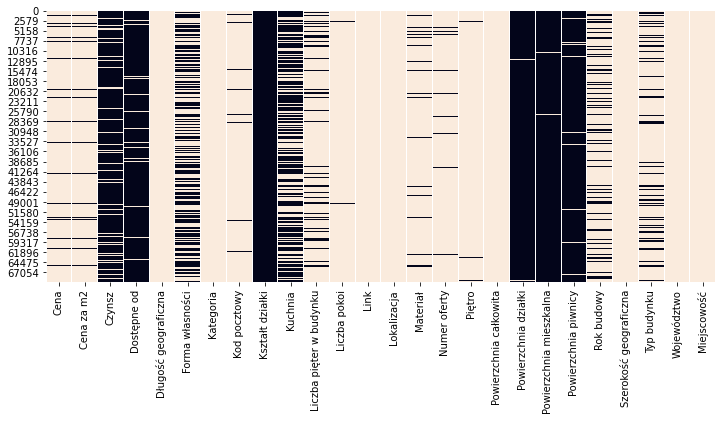

In [65]:
plt.subplots(figsize=(12,5))
sns.heatmap(df_pd.isnull(), cmap='rocket_r', cbar=False)

##### Zmienne numeryczne

In [66]:
# df.describe().show(vertical=True) # w przypadku spark - gorsza widoczność
df_ks.describe()

Cena    Cena za m2       Czynsz  Długość geograficzna  Liczba pięter w budynku  Liczba pokoi        Piętro  Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  Powierzchnia piwnicy    Rok budowy  Szerokość geograficzna
count  6.468700e+04  64656.000000  9141.000000          69581.000000             59831.000000  68907.000000  68746.000000            69548.000000            183.000000               708.000000           3069.000000  57432.000000            69581.000000
mean   5.686810e+05   9135.631112   436.778799             19.324000                 5.269075      2.699015      2.682614               61.288478            180.849781                59.499873              6.633210   2002.217858               51.835585
std    4.544447e+05   4179.914371   197.294488              1.950541                 3.836089      0.973762      2.807769               26.065021            218.611826                22.013715             11.554288     28.287742                1.270498
min    2.900000e+04   1000.000000     0.000000             14.138441                 0.000000      1.000000      0.000000               20.000000              0.000000                22.000000              0.000000   1900.000000               49.037855
25%    3.350000e+05   6299.999675   990.000000             17.929884                 3.000000      2.000000      1.000000               44.700000              0.000000                44.000000              3.000000   1989.000000               50.899912
50%    4.572000e+05   8450.000204   439.000000             19.936856                 4.000000      3.000000      2.000000               56.000000             75.000000                55.170000              4.000000   2019.000000               52.174288
75%    6.380000e+05  11110.090909   550.000000             20.991544                 6.000000      3.000000      4.000000              200.000000            305.000000                70.000000              7.000000   2021.000000               52.319005
max    9.700000e+06  49933.333333   990.000000             23.887616                88.000000     10.000000     81.000000              200.000000            900.000000               189.020000            469.000000   2024.000000               54.831120

In [67]:
df_pd.describe()

Cena    Cena za m2       Czynsz  Długość geograficzna  \
count  6.468700e+04  64656.000000  9141.000000          69581.000000   
mean   5.686818e+05   9135.631112   436.778809             19.324000   
std    4.544448e+05   4179.914371   197.294342              1.950541   
min    2.900000e+04   1000.000000     0.000000             14.138441   
25%    3.350000e+05   6299.999718   310.000000             17.929884   
50%    4.572750e+05   8450.007975   439.000000             19.936856   
75%    6.380000e+05  11111.097179   550.000000             20.991700   
max    9.700000e+06  49933.333333   990.000000             23.887616   

       Liczba pięter w budynku  Liczba pokoi        Piętro  \
count             59831.000000  68907.000000  68746.000000   
mean                  5.269075      2.699015      2.682614   
std                   3.836089      0.973762      2.807769   
min                   0.000000      1.000000      0.000000   
25%                   3.000000      2.000000      1.000000   
50%                   4.000000      3.000000      2.000000   
75%                   6.000000      3.000000      4.000000   
max                  88.000000     10.000000     81.000000   

       Powierzchnia całkowita  Powierzchnia działki  Powierzchnia mieszkalna  \
count            69548.000000            183.000000               708.000000   
mean                61.288471            180.849762                59.499897   
std                 26.064997            218.611847                22.013723   
min                 20.000000              0.000000                22.000000   
25%                 44.709999              0.000000                44.082500   
50%                 56.000000             75.000000                55.384998   
75%                 70.400002            302.500000                70.000000   
max                200.000000            900.000000               189.020004   

       Powierzchnia piwnicy    Rok budowy  Szerokość geograficzna  
count           3069.000000  57432.000000            69581.000000  
mean               6.633210   2002.217858               51.835585  
std               11.554288     28.287742                1.270498  
min                0.000000   1900.000000               49.037855  
25%                3.000000   1989.000000               50.898688  
50%                4.000000   2019.000000               52.174086  
75%                7.000000   2021.000000               52.319005  
max              469.000000   2024.000000               54.831120

In [68]:
df_ks.describe().T.to_excel("tabele/df_describe.xlsx")

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Administrator\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Administrator\anaconda3\lib\site

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000072255E1888>,
      dtype=object)

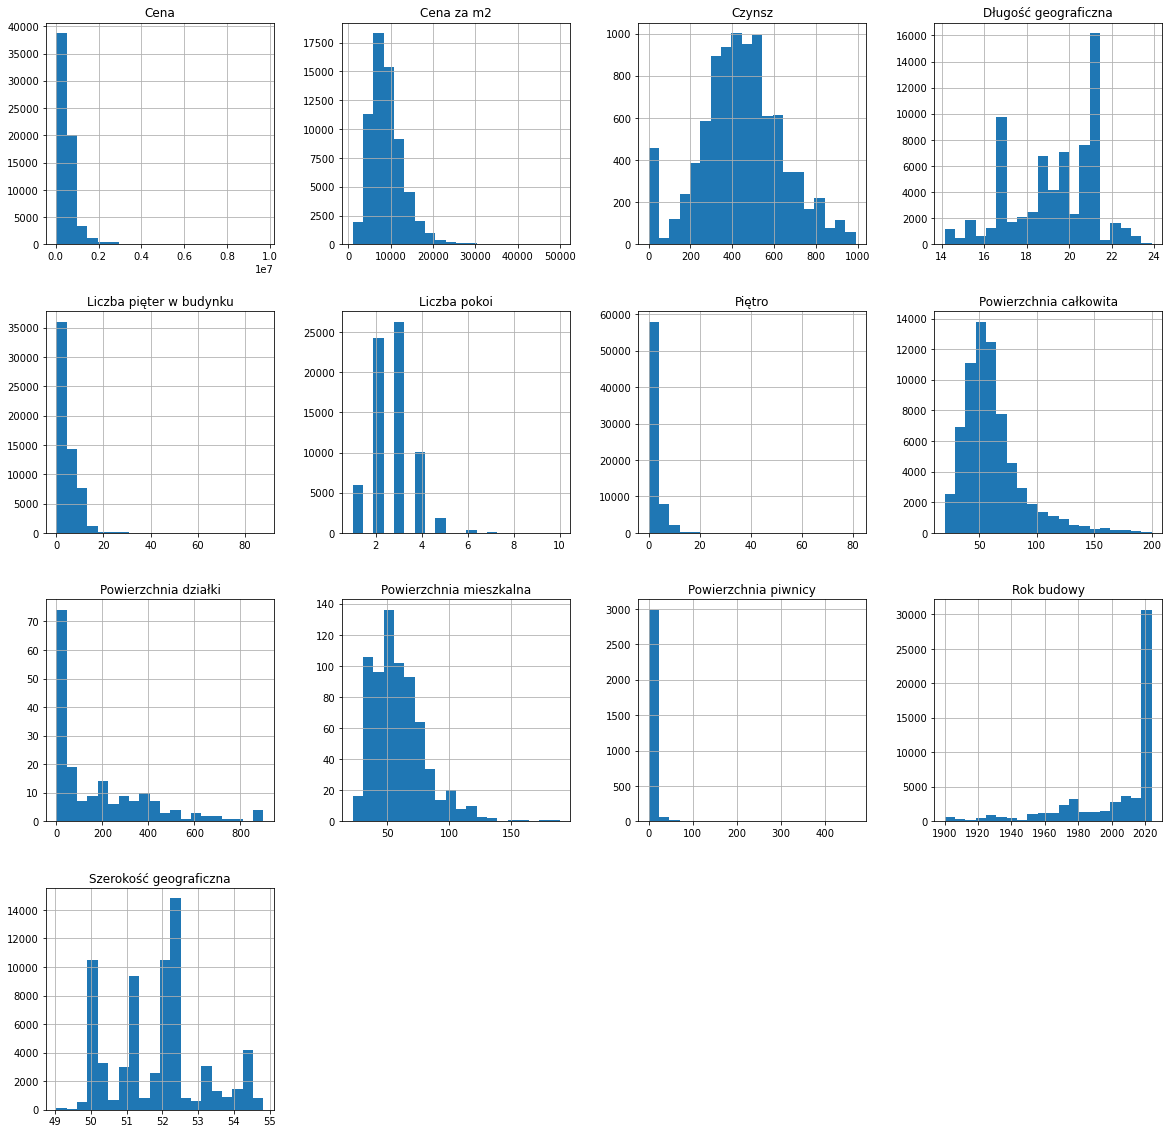

In [69]:
df_pd.hist(bins=20, figsize=(20,20))

##### Zmienne nienumeryczne

In [70]:
df.groupBy("Forma własności").count().orderBy(f.desc("count")).show(truncate=False)
df.select(f.countDistinct("Forma własności")).show()

+-----------------------------------+-----+
|Forma własności                    |count|
+-----------------------------------+-----+
|null                               |36061|
|własność                           |16112|
|Własność                           |8550 |
|spółdzielcze własnościowe          |1538 |
|Odrębna własność lokalu            |1479 |
|spółdzielcze własnościowe z kw     |892  |
|Spółdzielcze własnościowe          |854  |
|własność hipoteczna                |700  |
|PEŁNA WŁASNOŚĆ                     |403  |
|Spółdzielcze wł. z KW              |305  |
|Umowa z developerem                |235  |
|Spółdzielcza własnościowa z KW     |210  |
|ODRĘBNA WŁASNOŚĆ                   |196  |
|hipoteczne                         |192  |
|Spółdzielcza własnościowa bez KW   |165  |
|Spółdzielcze wł. - księga          |148  |
|Odrębna własność                   |148  |
|SPÓŁDZIELCZE WŁASNOŚCIOWE Z KW     |139  |
|spółdzielcze + kw                  |136  |
|odrębna własność z Księgą Wiecz

In [71]:
df.groupBy("Kuchnia").count().orderBy(f.desc("count")).show(truncate=False)
df.select(f.countDistinct("Kuchnia")).show()

+-------------------------------------+-----+
|Kuchnia                              |count|
+-------------------------------------+-----+
|null                                 |36766|
|aneks kuchenny                       |4938 |
|aneks kuchenny - połączony z salonem |4323 |
|oddzielna                            |3977 |
|aneks                                |3505 |
|z oknem                              |2159 |
|otwarta                              |2057 |
|Aneks kuchenny0                      |1656 |
|widna                                |1462 |
|jasna z oknem                        |1256 |
|Kuchnia zamykana z oknem             |585  |
|Kuchnia otwarta z oknem              |523  |
|Jasna, oddzielna0                    |517  |
|zamknięta                            |470  |
|w aneksie                            |420  |
|półotwarta                           |394  |
|aneks kuchenny - połączony z jadalnią|312  |
|Jasna0                               |305  |
|oddzielna i widna                

In [72]:
df.groupBy("Materiał").count().orderBy(f.desc("count")).show(truncate=False)
df.select(f.countDistinct("Materiał")).show()

+------------+-----+
|Materiał    |count|
+------------+-----+
|inny        |35259|
|cegła       |15473|
|null        |4493 |
|beton       |4492 |
|wielka płyta|4170 |
|pustak      |3032 |
|rama h      |1173 |
|ytong       |950  |
|silikat     |554  |
|drewno      |17   |
+------------+-----+

+------------------------+
|count(DISTINCT Materiał)|
+------------------------+
|                       9|
+------------------------+



In [73]:
df.groupBy("Typ budynku").count().orderBy(f.desc("count")).show(truncate=False)
df.select(f.countDistinct("Typ budynku")).show()

+-----------------+-----+
|Typ budynku      |count|
+-----------------+-----+
|blok             |22003|
|inny             |17830|
|apartamentowiec  |12728|
|null             |10875|
|kamienica        |5889 |
|dom wielorodzinny|288  |
+-----------------+-----+

+---------------------------+
|count(DISTINCT Typ budynku)|
+---------------------------+
|                          5|
+---------------------------+



Dodanie kolumny z miejscowością

In [74]:
df = df.withColumn("Miejscowość", f.initcap(f.split("Lokalizacja", ", ")[0]))

In [75]:
df.groupBy("Miejscowość")\
.agg(f.count("Miejscowość").alias("Liczba ogłoszeń"))\
.orderBy("Liczba ogłoszeń", ascending=False)\
.show()

+-------------------+---------------+
|        Miejscowość|Liczba ogłoszeń|
+-------------------+---------------+
|           Warszawa|          20279|
|            Wrocław|           7900|
|             Kraków|           7505|
|             Gdańsk|           2928|
|               Łódź|           2089|
|             Poznań|           1982|
|          Bydgoszcz|           1851|
|            Rzeszów|           1306|
|           Katowice|           1227|
|             Lublin|           1012|
|           Szczecin|            916|
|             Kielce|            890|
|        Częstochowa|            874|
|             Gdynia|            846|
|          Kołobrzeg|            720|
|            Gliwice|            530|
|          Białystok|            527|
|          Wieliczka|            466|
|              Opole|            466|
|Gorzów Wielkopolski|            376|
+-------------------+---------------+
only showing top 20 rows



##### Dostępność ofert

Podział na rynek pierwotny i wtórny

In [76]:
df.withColumn("Rodzaj rynku", f.when(df["Rok budowy"] >= 2021, "pierwotny").when(df["Rok budowy"] < 2021, "wtórny"))\
.groupBy("Rodzaj rynku")\
.count()\
.show()

+------------+-----+
|Rodzaj rynku|count|
+------------+-----+
|        null|12181|
|   pierwotny|20219|
|      wtórny|37213|
+------------+-----+



In [77]:
df.withColumn("Rodzaj rynku", f.when(df["Rok budowy"] >= 2021, "pierwotny").when(df["Rok budowy"] < 2021, "wtórny"))\
.groupBy("Rodzaj rynku", "Miejscowość")\
.count()\
.orderBy("count", ascending=False)\
.show()

+------------+-----------+-----+
|Rodzaj rynku|Miejscowość|count|
+------------+-----------+-----+
|      wtórny|   Warszawa|13653|
|   pierwotny|   Warszawa| 4380|
|      wtórny|    Wrocław| 3719|
|   pierwotny|     Kraków| 3530|
|   pierwotny|    Wrocław| 3500|
|      wtórny|     Kraków| 3466|
|        null|   Warszawa| 2246|
|      wtórny|     Gdańsk| 1414|
|   pierwotny|     Gdańsk| 1392|
|      wtórny|  Bydgoszcz|  872|
|      wtórny|     Lublin|  848|
|      wtórny|     Poznań|  847|
|   pierwotny|     Poznań|  844|
|   pierwotny|       Łódź|  820|
|      wtórny|       Łódź|  772|
|   pierwotny|  Bydgoszcz|  726|
|        null|    Wrocław|  681|
|      wtórny|    Rzeszów|  679|
|      wtórny|     Gdynia|  625|
|      wtórny|   Katowice|  556|
+------------+-----------+-----+
only showing top 20 rows



In [78]:
windowSpec = Window.partitionBy("Miejscowość")
windowSpec2 = Window.partitionBy("Miejscowość", "Rodzaj rynku")

df_pd_tmp = df.select("Miejscowość", "Rok budowy")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 1000)\
.withColumn("Rodzaj rynku", f.when(df["Rok budowy"] >= 2021, "pierwotny").when(df["Rok budowy"] < 2021, "wtórny"))\
.withColumn("countRodzajRynku", f.count("Rodzaj rynku").over(windowSpec2))\
.orderBy("countRodzajRynku", ascending=False)\
.toPandas()

Text(0.5, 8.960000000000008, 'Liczba ofert')

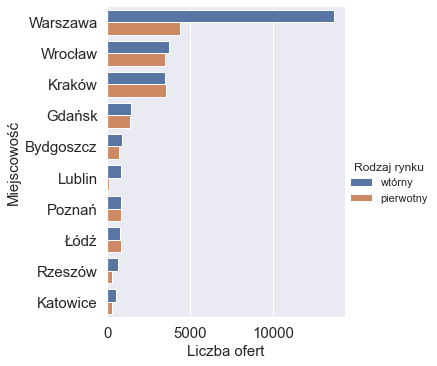

In [79]:
sns.set(rc={'figure.figsize':(25,15), "axes.labelsize":15, "xtick.labelsize":15, "ytick.labelsize":15})
sns.catplot(
    data=df_pd_tmp, kind="bar",
    x="countRodzajRynku", y="Miejscowość", hue="Rodzaj rynku"
)
plt.xlabel("Liczba ofert")

In [80]:
windowSpec = Window.partitionBy("Województwo", "Rodzaj rynku")

df_pd_tmp = df.select("Województwo", "Rok budowy")\
.withColumn("Rodzaj rynku", f.when(df["Rok budowy"] >= 2021, "pierwotny").when(df["Rok budowy"] < 2021, "wtórny"))\
.withColumn("countRodzajRynku", f.count("Rodzaj rynku").over(windowSpec))\
.orderBy("countRodzajRynku", ascending=False)\
.toPandas()

Text(0.5, 8.960000000000008, 'Liczba ofert')

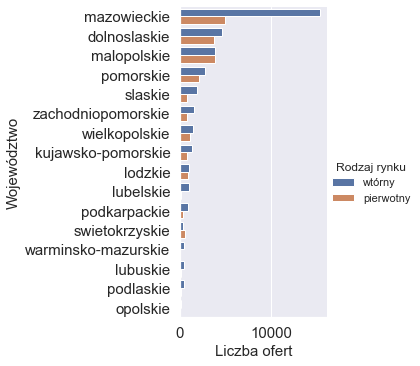

In [81]:
sns.set(rc={'figure.figsize':(25,15), "axes.labelsize":15, "xtick.labelsize":15, "ytick.labelsize":15})
sns.catplot(
    data=df_pd_tmp, kind="bar",
    x="countRodzajRynku", y="Województwo", hue="Rodzaj rynku"
)
plt.xlabel("Liczba ofert")

Podział na materiał

In [82]:
windowSpec = Window.partitionBy("Miejscowość")
windowSpec2 = Window.partitionBy("Miejscowość", "Materiał")

df_pd_tmp = df.select("Miejscowość", "Materiał")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 1000)\
.withColumn("countTypBudynku", f.count("Materiał").over(windowSpec2))\
.orderBy("countTypBudynku", ascending=False)\
.toPandas()

Text(0.5, 8.960000000000008, 'Liczba ofert')

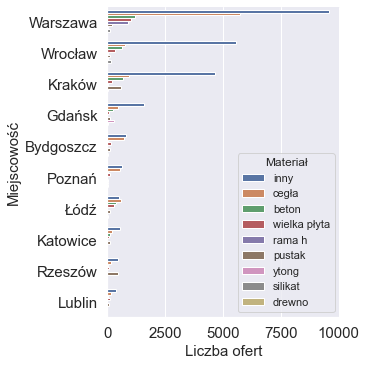

In [83]:
sns.set(rc={'figure.figsize':(15,15), "axes.labelsize":15, "xtick.labelsize":15, "ytick.labelsize":15})
sns.catplot(
    data=df_pd_tmp, kind="bar",
    x="countTypBudynku", y="Miejscowość", hue="Materiał", legend_out=False
)
plt.xlabel("Liczba ofert")

Podział na typ budynku

In [84]:
windowSpec = Window.partitionBy("Miejscowość")
windowSpec2 = Window.partitionBy("Miejscowość", "Typ budynku")

df_pd_tmp = df.select("Miejscowość", "Typ budynku")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 1000)\
.withColumn("countTypBudynku", f.count("Typ budynku").over(windowSpec2))\
.orderBy("countTypBudynku", ascending=False)\
.toPandas()

Text(0.5, 8.960000000000008, 'Liczba ofert')

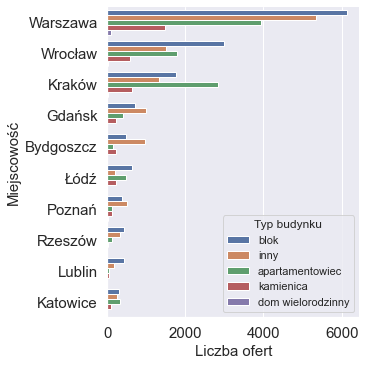

In [85]:
sns.set(rc={'figure.figsize':(15,15), "axes.labelsize":15, "xtick.labelsize":15, "ytick.labelsize":15})
sns.catplot(
    data=df_pd_tmp, kind="bar",
    x="countTypBudynku", y="Miejscowość", hue="Typ budynku", legend_out=False
)
plt.xlabel("Liczba ofert")

# Analiza cen

### Ceny w województwach

##### Ceny

Średnie ceny i średnie ceny za m2 posortowane wg średniej za m2

In [86]:
df.select("Cena", "Cena za m2", "Województwo")\
.groupBy("Województwo")\
.agg(f.round(f.avg("Cena"), 3).alias("Średnia cena"), f.round(f.avg("Cena za m2"), 3).alias("Średnia cena za m2"))\
.orderBy("Średnia cena za m2", ascending=False)\
.show()

+-------------------+------------+------------------+
|        Województwo|Średnia cena|Średnia cena za m2|
+-------------------+------------+------------------+
|        mazowieckie|  801766.297|         11841.091|
|        malopolskie|  589790.548|         10347.907|
|          pomorskie|   603828.93|          9875.829|
|       dolnoslaskie|  482493.871|          8195.708|
| zachodniopomorskie|  454736.477|          8092.072|
|          lubelskie|   399061.25|          6733.439|
|          podlaskie|  364973.391|          6648.773|
|      wielkopolskie|   368754.66|          6409.008|
| kujawsko-pomorskie|  374127.152|          6399.788|
|       podkarpackie|  379304.827|          6327.027|
|     swietokrzyskie|  398810.212|          6306.969|
|            lodzkie|  348268.021|          6249.872|
|warminsko-mazurskie|   351746.38|          5626.897|
|            slaskie|  323212.457|          5620.455|
|           opolskie|    352850.3|          5251.873|
|           lubuskie|  29288

Średnie ceny i średnie ceny za m2 posortowane wg liczby ogłoszeń

In [87]:
df.select("Cena", "Cena za m2", "Województwo")\
.groupBy("Województwo")\
.agg(f.count("Województwo").alias("Liczba ogłoszeń"),\
     f.round(f.avg("Cena"), 3).alias("Średnia cena"),\
     f.round(f.avg("Cena za m2"), 3).alias("Średnia cena za m2"))\
.orderBy("Liczba ogłoszeń", ascending=False)\
.show()

+-------------------+---------------+------------+------------------+
|        Województwo|Liczba ogłoszeń|Średnia cena|Średnia cena za m2|
+-------------------+---------------+------------+------------------+
|        mazowieckie|          22812|  801766.297|         11841.091|
|       dolnoslaskie|           9860|  482493.871|          8195.708|
|        malopolskie|           8588|  589790.548|         10347.907|
|          pomorskie|           5220|   603828.93|          9875.829|
|            slaskie|           4695|  323212.457|          5620.455|
|      wielkopolskie|           3472|   368754.66|          6409.008|
| zachodniopomorskie|           2926|  454736.477|          8092.072|
| kujawsko-pomorskie|           2672|  374127.152|          6399.788|
|            lodzkie|           2535|  348268.021|          6249.872|
|       podkarpackie|           1650|  379304.827|          6327.027|
|          lubelskie|           1195|   399061.25|          6733.439|
|     swietokrzyskie

##### Wizualizacja cen

Średnie ceny posortowane po średniej z ceny - wizualizacja

In [88]:
windowSpec = Window.partitionBy("Województwo")

df_pd_tmp = df.select("Cena", "Cena za m2", "Województwo")\
.withColumn("cenaAvg", f.mean("Cena").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

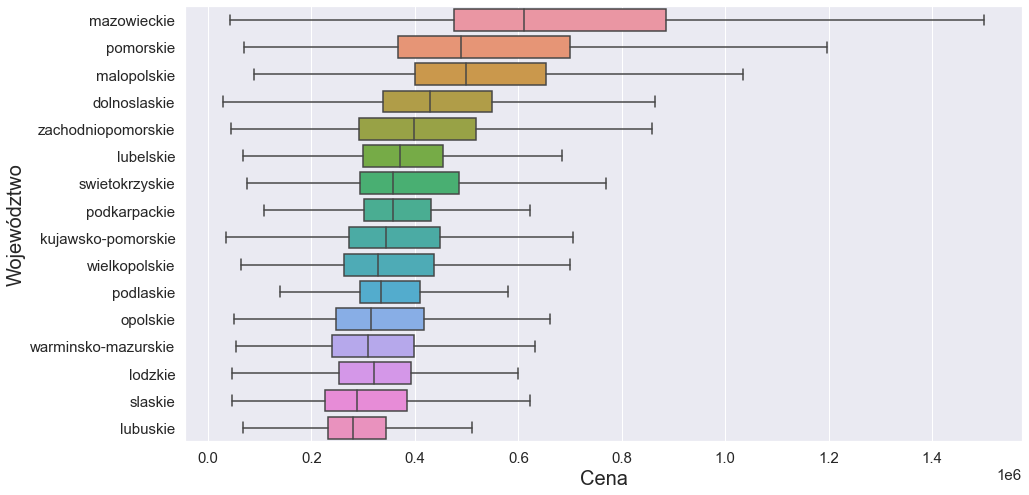

In [89]:
sns.set(rc={'figure.figsize':(15,8), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena", y="Województwo", data=df_pd_tmp, showfliers=False)

Średnie ceny posortowane po średniej z ceny w podziale na rynek pierwotny i wtórny - wizualizacja

In [90]:
df_pd_tmp = df.select("Cena", "Cena za m2", "Województwo", "Rok budowy")\
.withColumn("Rodzaj rynku", f.when(df["Rok budowy"] >= 2021, "pierwotny").when(df["Rok budowy"] < 2021, "wtórny"))\
.withColumn("cenaAvg", f.mean("Cena").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

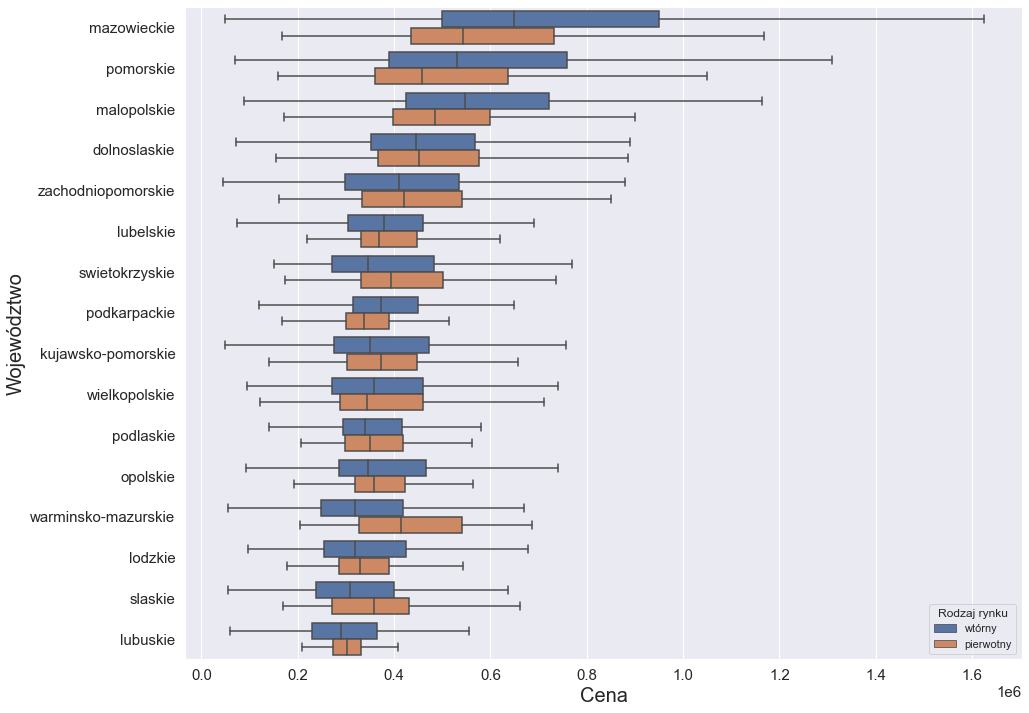

In [91]:
sns.set(rc={'figure.figsize':(15,12), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena", y="Województwo", data=df_pd_tmp, hue="Rodzaj rynku", showfliers=False)

##### Wizualizacja cen za m2

Średnie ceny za m2 posortowane wg średniej za m2 - wizualizacja

In [92]:
windowSpec = Window.partitionBy("Województwo")

df_pd_tmp = df.select("Cena", "Cena za m2", "Województwo")\
.withColumn("cenaAvg", f.mean("Cena za m2").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

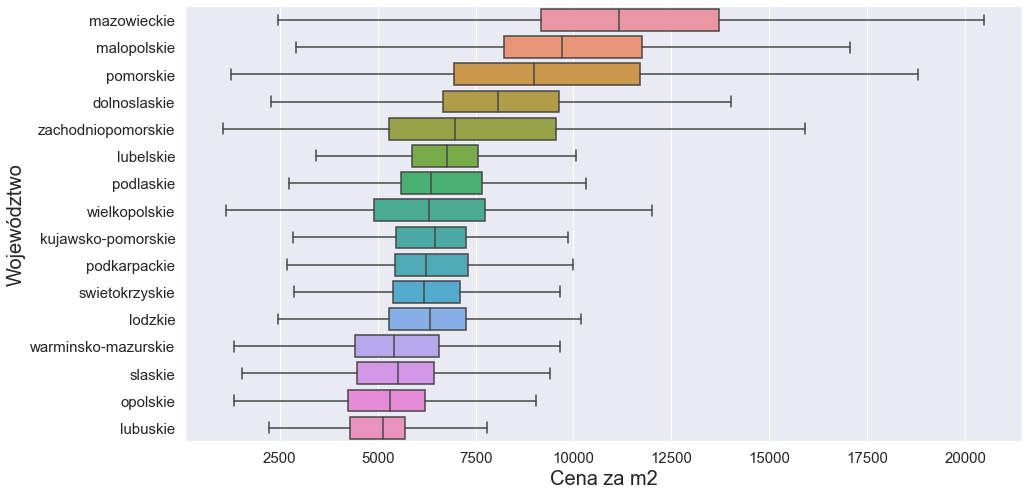

In [93]:
sns.set(rc={'figure.figsize':(15,8), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena za m2", y="Województwo", data=df_pd_tmp, showfliers=False)

Średnie ceny za m2 posortowane wg średniej za m2 w podziale na rynek pierwotny i wtórny - wizualizacja

In [94]:
df_pd_tmp = df.select("Cena", "Cena za m2", "Województwo", "Rok budowy")\
.withColumn("Rodzaj rynku", f.when(df["Rok budowy"] >= 2021, "pierwotny").when(df["Rok budowy"] < 2021, "wtórny"))\
.withColumn("cenaAvg", f.mean("Cena za m2").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

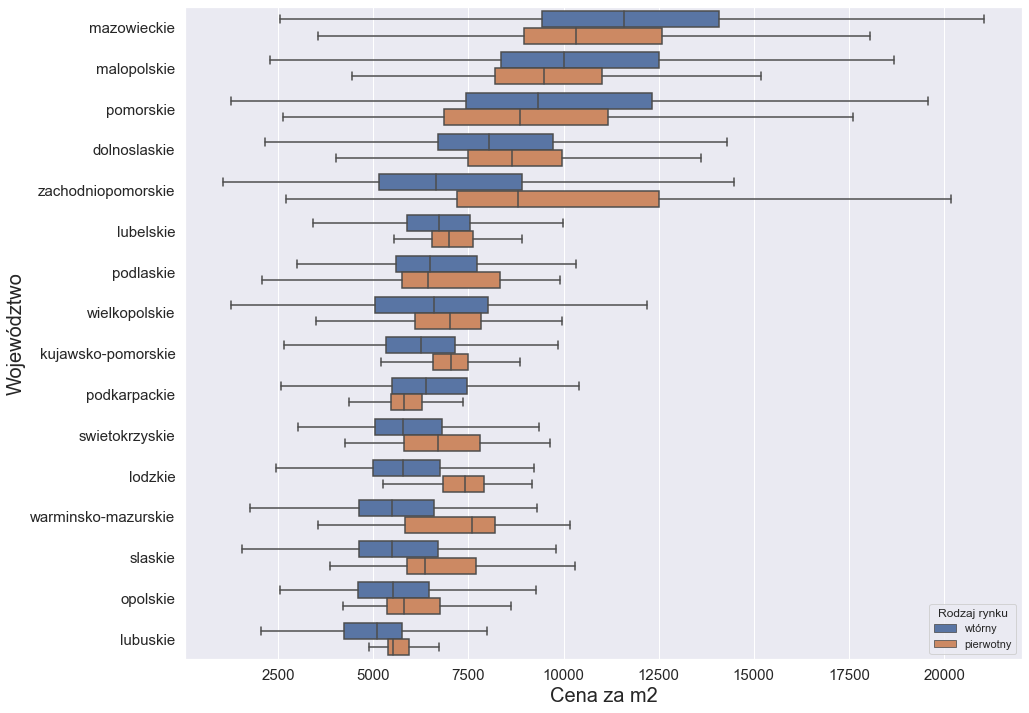

In [95]:
sns.set(rc={'figure.figsize':(15,12), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena za m2", y="Województwo", data=df_pd_tmp, hue="Rodzaj rynku", showfliers=False)

### Ceny w miastach

##### Ceny

Średnie ceny i średnie ceny za m2 posortowane wg średniej za m2

In [96]:
df.select("Cena", "Cena za m2", "Miejscowość")\
.groupBy("Miejscowość")\
.agg(f.round(f.avg("Cena"), 3).alias("Średnia cena"), f.round(f.avg("Cena za m2"), 3).alias("Średnia cena za m2"))\
.orderBy("Średnia cena za m2", ascending=False)\
.show()

+--------------------+------------+------------------+
|         Miejscowość|Średnia cena|Średnia cena za m2|
+--------------------+------------+------------------+
|           Jastarnia|   2171000.0|         32309.462|
|              Jurata| 1995426.667|         24765.318|
|            Wiślinka|  1113648.55|         20511.086|
|              Rogowo|    895760.0|         18613.809|
|        Władysławowo|   1156500.0|         17721.203|
|            Zakopane|  919124.808|         17292.665|
|        Międzyzdroje| 1078107.377|         17005.137|
|         Kościelisko|  777268.368|         15292.291|
|         Pogorzelica|    573000.0|         15078.947|
|Warszawa Śródmieście|   1255144.0|           14960.0|
| Bukowina Tatrzańska|    767300.0|         14854.453|
|            Chłapowo|    950000.0|          14843.75|
|             Szczyrk|    621640.0|         14470.117|
|   Białka Tatrzańska|  479795.167|         14423.241|
|               Sopot| 1076644.526|          14343.45|
|         

Średnie ceny i średnie ceny za m2 w top 20 miastach z największą liczbą ogłoszeń posortowane wg liczby ogłoszeń

In [97]:
df.select("Cena", "Cena za m2", "Miejscowość")\
.groupBy("Miejscowość")\
.agg(f.count("Miejscowość").alias("Liczba ogłoszeń"),\
     f.round(f.avg("Cena"), 3).alias("Średnia cena"),\
     f.round(f.avg("Cena za m2"), 3).alias("Średnia cena za m2"))\
.orderBy("Liczba ogłoszeń", ascending=False)\
.show(20)

+-------------------+---------------+------------+------------------+
|        Miejscowość|Liczba ogłoszeń|Średnia cena|Średnia cena za m2|
+-------------------+---------------+------------+------------------+
|           Warszawa|          20279|  845071.573|         12470.812|
|            Wrocław|           7900|   532340.03|          9117.402|
|             Kraków|           7505|  609430.834|         10687.033|
|             Gdańsk|           2928|  666522.091|         11107.447|
|               Łódź|           2089|  362903.727|          6617.372|
|             Poznań|           1982|  442385.302|          7769.082|
|          Bydgoszcz|           1851|  393411.161|          6786.062|
|            Rzeszów|           1306|   405580.19|          6797.088|
|           Katowice|           1227|  425455.565|          7154.569|
|             Lublin|           1012|  427859.584|          7147.804|
|           Szczecin|            916|  478846.438|           7206.74|
|             Kielce

Średnie ceny i średnie ceny za m2 posortowane wg średniej za m2, przy liczbie ogłoszeń >= 100 i >=1000 na miasto

In [98]:
windowSpec = Window.partitionBy("Miejscowość")

df.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") > 100)\
.select("Cena", "Cena za m2", "Miejscowość")\
.groupBy("Miejscowość")\
.agg(f.round(f.avg("Cena"), 3).alias("Średnia cena"),\
     f.round(f.avg("Cena za m2"), 3).alias("Średnia cena za m2"))\
.orderBy("Średnia cena za m2", ascending=False)\
.show(20)

+------------+------------+------------------+
| Miejscowość|Średnia cena|Średnia cena za m2|
+------------+------------+------------------+
|Międzyzdroje| 1078107.377|         17005.137|
|       Sopot| 1076644.526|          14343.45|
|    Warszawa|  845071.573|         12470.812|
|      Gdańsk|  666522.091|         11107.447|
|      Kraków|  609430.834|         10687.033|
|   Kołobrzeg|  510300.481|         10224.017|
|      Gdynia|  633413.135|         10103.811|
|      Krakow|  511557.038|         10012.866|
|     Wrocław|   532340.03|          9117.402|
|  Józefosław|  610833.994|          8331.254|
|    Pruszków|  470414.777|          8162.732|
|       Ząbki|  503818.685|          7935.523|
|      Poznań|  442385.302|          7769.082|
|   Piaseczno|  554684.942|          7622.505|
|    Szczecin|  478846.438|           7206.74|
|   Wieliczka|  391336.597|          7158.238|
|    Katowice|  425455.565|          7154.569|
|      Lublin|  427859.584|          7147.804|
|   Białystok

In [99]:
df.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") > 1000)\
.select("Cena", "Cena za m2", "Miejscowość")\
.groupBy("Miejscowość")\
.agg(f.round(f.avg("Cena"), 3).alias("Średnia cena"),\
     f.round(f.avg("Cena za m2"), 3).alias("Średnia cena za m2"))\
.orderBy("Średnia cena za m2", ascending=False)\
.show(20)

+-----------+------------+------------------+
|Miejscowość|Średnia cena|Średnia cena za m2|
+-----------+------------+------------------+
|   Warszawa|  845071.573|         12470.812|
|     Gdańsk|  666522.091|         11107.447|
|     Kraków|  609430.834|         10687.033|
|    Wrocław|   532340.03|          9117.402|
|     Poznań|  442385.302|          7769.082|
|   Katowice|  425455.565|          7154.569|
|     Lublin|  427859.584|          7147.804|
|    Rzeszów|   405580.19|          6797.088|
|  Bydgoszcz|  393411.161|          6786.062|
|       Łódź|  362903.727|          6617.372|
+-----------+------------+------------------+



##### Wizualizacja cen

Średnie ceny posortowane po średniej z ceny, przy liczbie ogłoszeń >=1000 na miasto - wizualizacja

In [100]:
windowSpec = Window.partitionBy("Miejscowość")

df_pd_tmp = df.select("Cena", "Cena za m2", "Miejscowość")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 1000)\
.withColumn("cenaAvg", f.mean("Cena").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

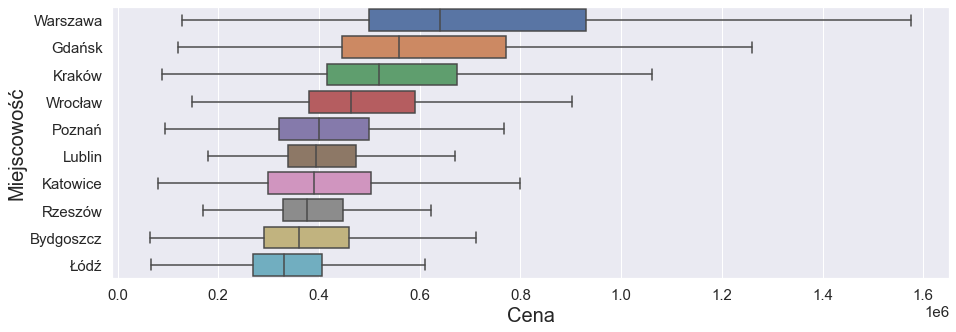

In [101]:
sns.set(rc={'figure.figsize':(15,5), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena", y="Miejscowość", data=df_pd_tmp, showfliers=False)
# plt.xlim(left=0, right=2000000)

Średnie ceny posortowane po średniej z ceny w podziale na rynek pierwotny i wtórny, przy liczbie ogłoszeń >=1000 na miasto - wizualizacja

In [102]:
df_pd_tmp = df.select("Cena", "Cena za m2", "Miejscowość", "Rok budowy")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 1000)\
.withColumn("Rodzaj rynku", f.when(df["Rok budowy"] >= 2021, "pierwotny").when(df["Rok budowy"] < 2021, "wtórny"))\
.withColumn("cenaAvg", f.mean("Cena").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

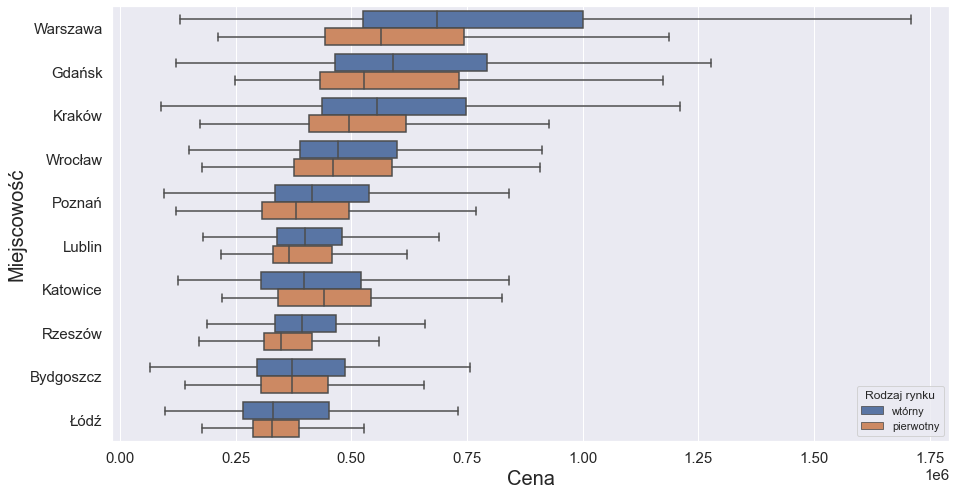

In [103]:
sns.set(rc={'figure.figsize':(15,8), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena", y="Miejscowość", data=df_pd_tmp, hue="Rodzaj rynku", showfliers=False)

Średnie ceny posortowane po średniej z ceny, przy liczbie ogłoszeń >=100 na miasto - wizualizacja

In [104]:
df_pd_tmp = df.select("Cena", "Cena za m2", "Miejscowość")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 100)\
.withColumn("cenaAvg", f.mean("Cena").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

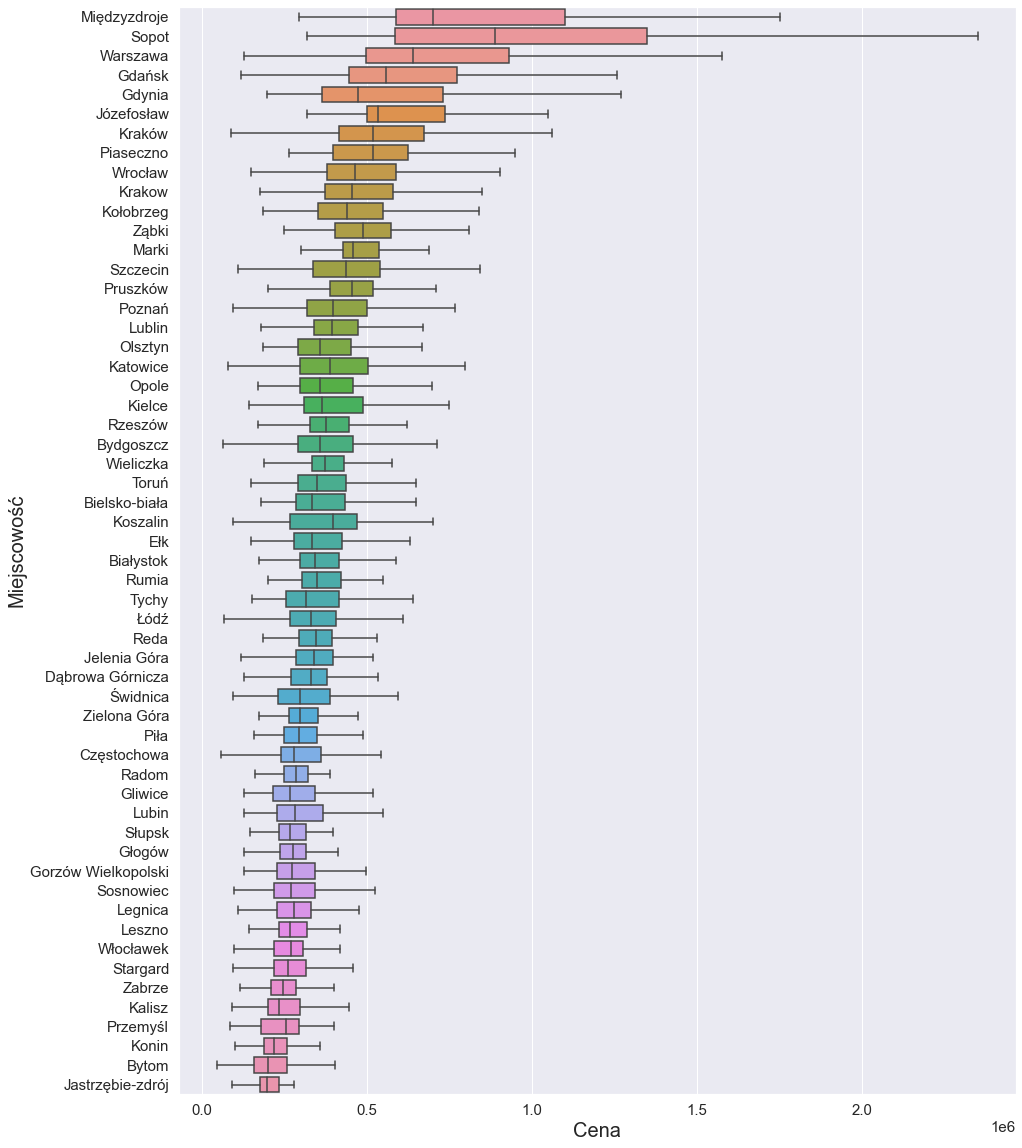

In [105]:
sns.set(rc={'figure.figsize':(15,20), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena", y="Miejscowość", data=df_pd_tmp, showfliers=False)

##### Wizualizacja cen za m2

Średnie ceny za m2 posortowane wg średniej za m2, przy liczbie ogłoszeń >=1000 na miasto - wizualizacja

In [106]:
df_pd_tmp = df.select("Cena", "Cena za m2", "Miejscowość")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 1000)\
.withColumn("cenaAvg", f.mean("Cena za m2").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

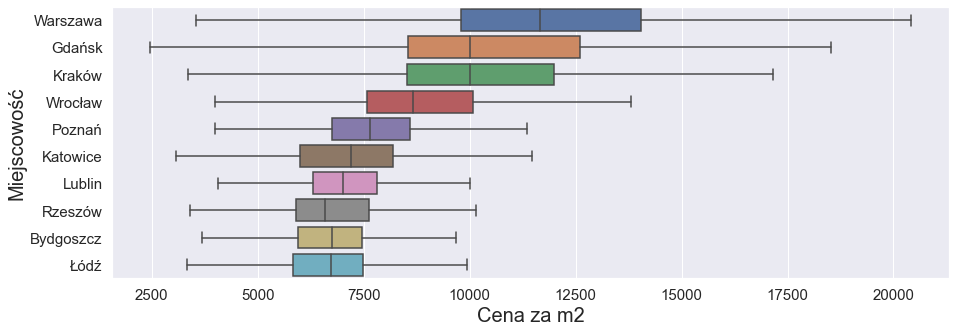

In [107]:
sns.set(rc={'figure.figsize':(15,5), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena za m2", y="Miejscowość", data=df_pd_tmp, showfliers=False)

Średnie ceny za m2 posortowane wg średniej za m2 w podziale na rynek pierwotny i wtórny, przy liczbie ogłoszeń >=1000 na miasto - wizualizacja

In [108]:
df_pd_tmp = df.select("Cena", "Cena za m2", "Miejscowość", "Rok budowy")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 1000)\
.withColumn("Rodzaj rynku", f.when(df["Rok budowy"] >= 2021, "pierwotny").when(df["Rok budowy"] < 2021, "wtórny"))\
.withColumn("cenaAvg", f.mean("Cena za m2").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

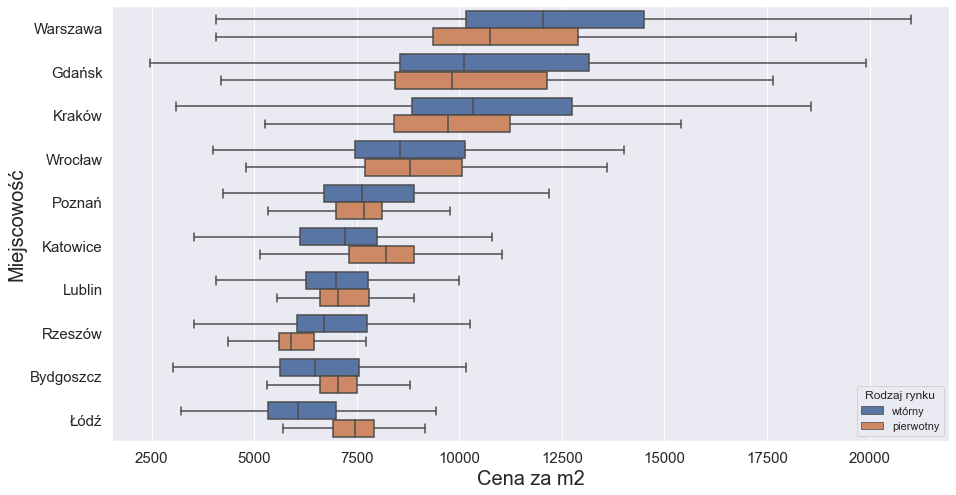

In [109]:
sns.set(rc={'figure.figsize':(15,8), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena za m2", y="Miejscowość", data=df_pd_tmp, hue="Rodzaj rynku", showfliers=False)

Średnie ceny za m2 posortowane wg średniej za m2, przy liczbie ogłoszeń >=100 na miasto - wizualizacja

In [110]:
df_pd_tmp = df.select("Cena", "Cena za m2", "Miejscowość")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 100)\
.withColumn("cenaAvg", f.mean("Cena za m2").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

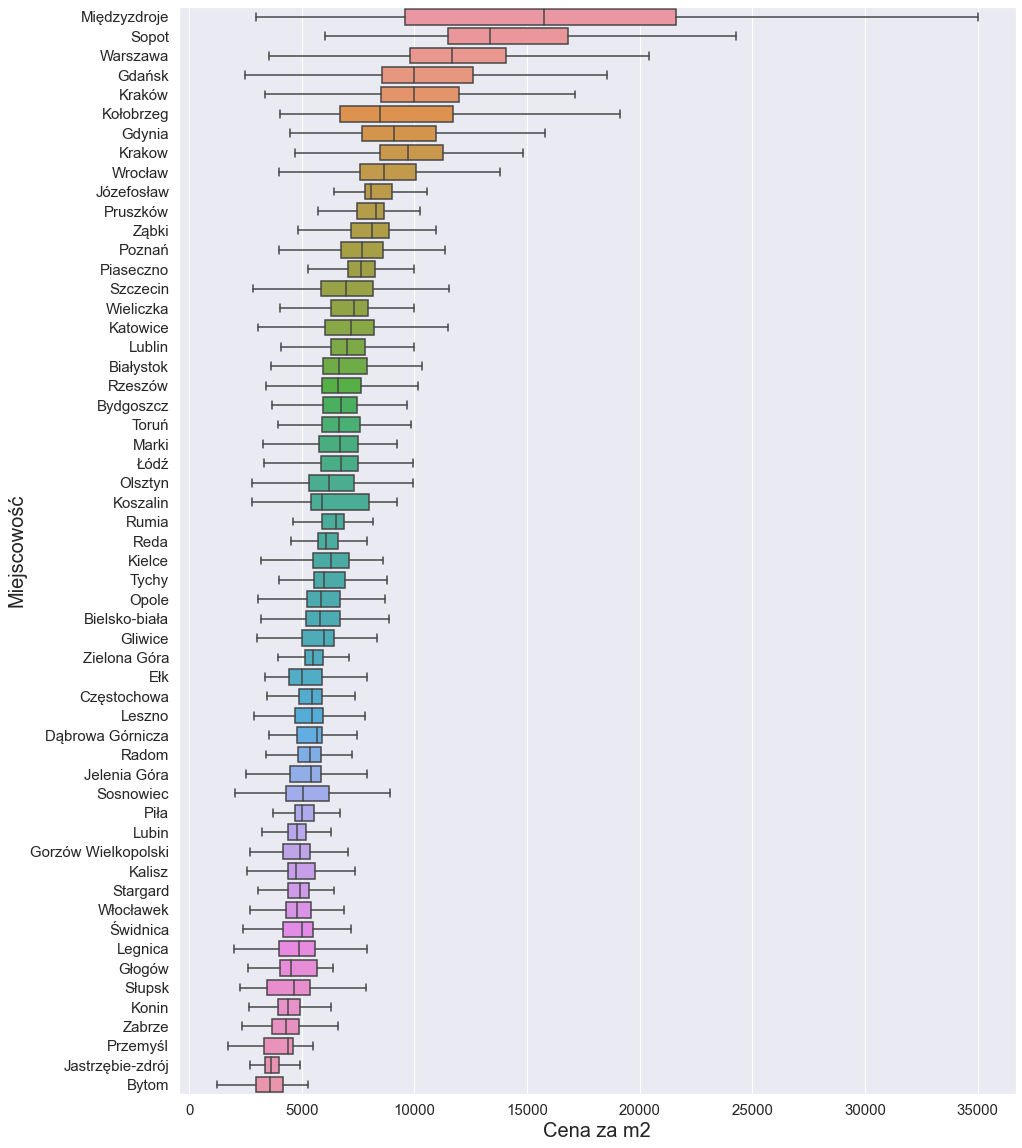

In [111]:
sns.set(rc={'figure.figsize':(15,20), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena za m2", y="Miejscowość", data=df_pd_tmp, showfliers=False)

### Ceny na mapie

##### Ceny

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
C:\Users\Administrator\anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:4790: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
C:\Users\Administrator\anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:4791: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
C:\Users\Administrator\anaconda3\lib\site-packages\mpl_toolkits\ba

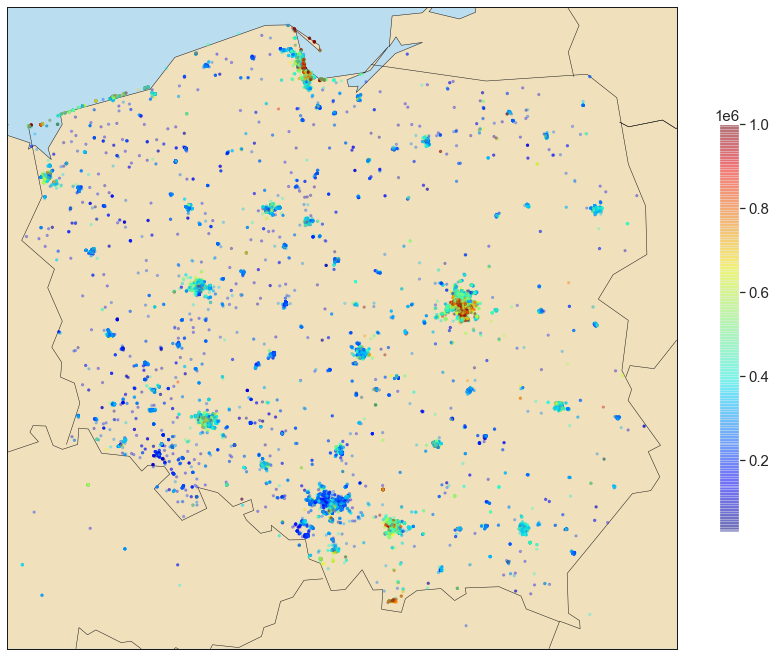

In [112]:
fig, ax = plt.subplots(figsize=(15,15))

m = Basemap(projection='merc', llcrnrlat=48.8, urcrnrlat=55, llcrnrlon=13.9, urcrnrlon=24.4, resolution='l')
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='#F0E0BB')
m.drawmapboundary(fill_color='#BBDDF0')
m.drawcountries()

longitudes = df_pd["Długość geograficzna"].tolist()
latitudes = df_pd["Szerokość geograficzna"].tolist()
price = df_pd["Cena"]

m.scatter(longitudes, latitudes, zorder=2, latlon=True, s=5, c=price, cmap='jet', alpha=0.3, vmax=1000000)

plt.colorbar(shrink=0.5)
plt.show()

##### Ceny za m2

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


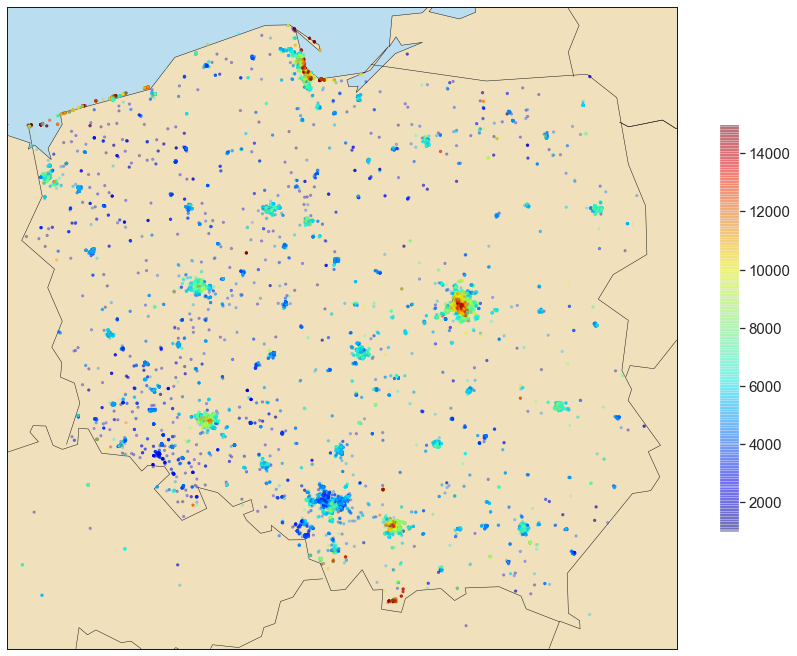

In [113]:
fig, ax = plt.subplots(figsize=(15,15))

m = Basemap(projection='merc', llcrnrlat=48.8, urcrnrlat=55, llcrnrlon=13.9, urcrnrlon=24.4, resolution='l')
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='#F0E0BB')
m.drawmapboundary(fill_color='#BBDDF0')
m.drawcountries()

longitudes = df_pd["Długość geograficzna"].tolist()
latitudes = df_pd["Szerokość geograficzna"].tolist()
price = df_pd["Cena za m2"]

m.scatter(longitudes, latitudes, zorder=2, latlon=True, s=5, c=price, cmap='jet', alpha=0.3, vmax=15000)

plt.colorbar(shrink=0.5)
plt.show()

### Ceny a materiał budynku

##### Cena

In [114]:
windowSpec = Window.partitionBy("Materiał")

df_pd_tmp = df.select("Cena", "Cena za m2", "Materiał")\
.withColumn("cenaAvg", f.mean("Cena").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

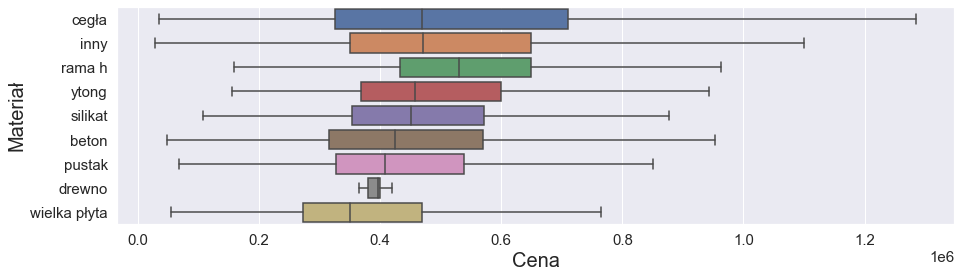

In [115]:
sns.set(rc={'figure.figsize':(15,4), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena", y="Materiał", data=df_pd_tmp, showfliers=False)

##### Cena za m2

In [116]:
df_pd_tmp = df.select("Cena", "Cena za m2", "Materiał")\
.withColumn("cenaAvg", f.mean("Cena za m2").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

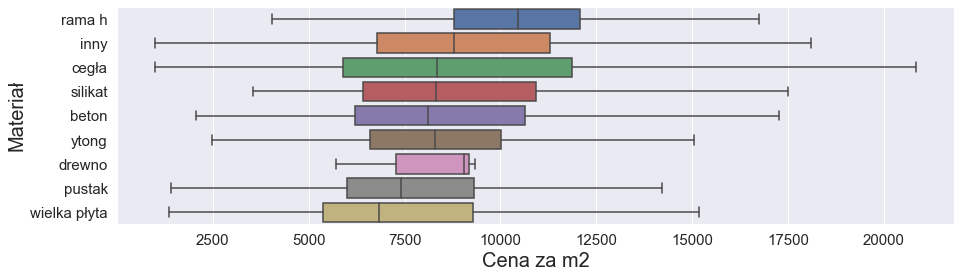

In [117]:
sns.set(rc={'figure.figsize':(15,4), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena za m2", y="Materiał", data=df_pd_tmp, showfliers=False)

### Ceny a typ budynku

##### Cena

In [118]:
windowSpec = Window.partitionBy("Typ budynku")

df_pd_tmp = df.select("Cena", "Cena za m2", "Typ budynku")\
.withColumn("cenaAvg", f.mean("Cena").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

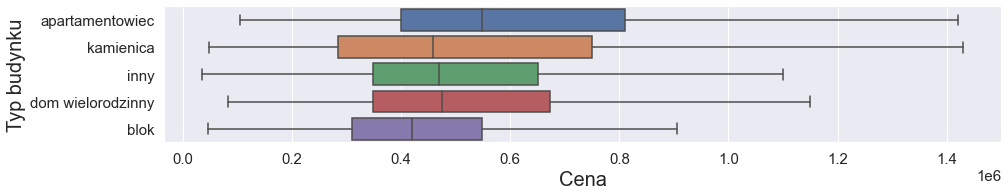

In [119]:
sns.set(rc={'figure.figsize':(15,2.5), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena", y="Typ budynku", data=df_pd_tmp, showfliers=False)

##### Cena za m2

In [120]:
df_pd_tmp = df.select("Cena", "Cena za m2", "Typ budynku")\
.withColumn("cenaAvg", f.mean("Cena za m2").over(windowSpec))\
.orderBy("cenaAvg", ascending=False)\
.toPandas()

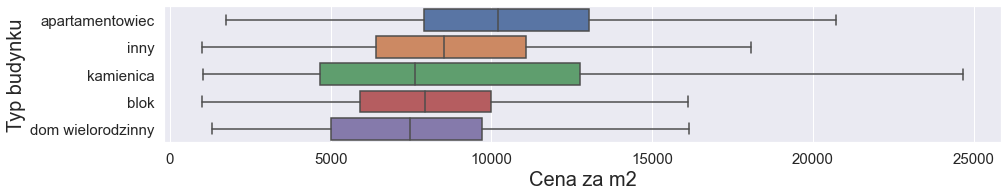

In [121]:
sns.set(rc={'figure.figsize':(15,2.5), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Cena za m2", y="Typ budynku", data=df_pd_tmp, showfliers=False)

# Szukanie zależności między pozostałymi zmiennymi

##### Korelacje

In [122]:
df_pd.corr()

Cena  Cena za m2    Czynsz  Długość geograficzna  \
Cena                     1.000000    0.697115  0.389810              0.220130   
Cena za m2               0.697115    1.000000  0.157423              0.285030   
Czynsz                   0.389810    0.157423  1.000000              0.131193   
Długość geograficzna     0.220130    0.285030  0.131193              1.000000   
Liczba pięter w budynku  0.212891    0.348791  0.201510              0.162920   
Liczba pokoi             0.397008   -0.104734  0.321227              0.039345   
Piętro                   0.222830    0.261243  0.159015              0.118004   
Powierzchnia całkowita   0.646811    0.029600  0.325759              0.061979   
Powierzchnia działki    -0.237083   -0.285464       NaN             -0.104843   
Powierzchnia mieszkalna  0.431851   -0.280918  0.758630             -0.086015   
Powierzchnia piwnicy     0.064334   -0.094801  0.002554             -0.099679   
Rok budowy               0.008380    0.039927 -0.094346             -0.027849   
Szerokość geograficzna   0.083954    0.097137  0.099352             -0.136318   

                         Liczba pięter w budynku  Liczba pokoi    Piętro  \
Cena                                    0.212891      0.397008  0.222830   
Cena za m2                              0.348791     -0.104734  0.261243   
Czynsz                                  0.201510      0.321227  0.159015   
Długość geograficzna                    0.162920      0.039345  0.118004   
Liczba pięter w budynku                 1.000000     -0.068550  0.686162   
Liczba pokoi                           -0.068550      1.000000  0.011391   
Piętro                                  0.686162      0.011391  1.000000   
Powierzchnia całkowita                 -0.063339      0.769698  0.025388   
Powierzchnia działki                   -0.414959      0.147887 -0.301860   
Powierzchnia mieszkalna                -0.119764      0.763211 -0.003117   
Powierzchnia piwnicy                   -0.178008      0.166410 -0.151244   
Rok budowy                              0.077747      0.006138  0.000588   
Szerokość geograficzna                  0.025188      0.002434  0.023452   

                         Powierzchnia całkowita  Powierzchnia działki  \
Cena                                   0.646811             -0.237083   
Cena za m2                             0.029600             -0.285464   
Czynsz                                 0.325759                   NaN   
Długość geograficzna                   0.061979             -0.104843   
Liczba pięter w budynku               -0.063339             -0.414959   
Liczba pokoi                           0.769698              0.147887   
Piętro                                 0.025388             -0.301860   
Powierzchnia całkowita                 1.000000              0.086896   
Powierzchnia działki                   0.086896              1.000000   
Powierzchnia mieszkalna                0.939554              0.448821   
Powierzchnia piwnicy                   0.242799              0.128446   
Rok budowy                            -0.051731             -0.129625   
Szerokość geograficzna                 0.028579              0.147275   

                         Powierzchnia mieszkalna  Powierzchnia piwnicy  \
Cena                                    0.431851              0.064334   
Cena za m2                             -0.280918             -0.094801   
Czynsz                                  0.758630              0.002554   
Długość geograficzna                   -0.086015             -0.099679   
Liczba pięter w budynku                -0.119764             -0.178008   
Liczba pokoi                            0.763211              0.166410   
Piętro                                 -0.003117             -0.151244   
Powierzchnia całkowita                  0.939554              0.242799   
Powierzchnia działki                    0.448821              0.128446   
Powierzchnia mieszkalna                 1.000000              0.36

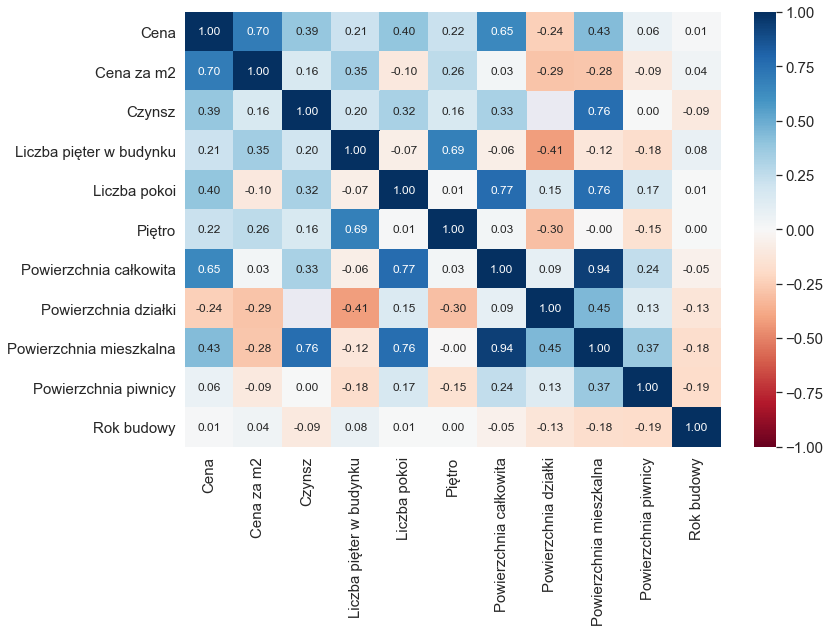

In [123]:
plt.subplots(figsize=(12,8))
sns.heatmap(df_pd.drop(["Długość geograficzna", "Szerokość geograficzna"], axis=1).corr(),
            cmap='RdBu', annot=True, fmt='.2f', cbar=True, vmin=-1, vmax=1)

Wnioski o cenie:
* Cena skorelowana z ceną z metra z uwagi na lokalizację
* Cena skorelowana z powierzchnią
* ~~Cena za m2 i Powierzchnia ujemna korelacja -> kawalerki najdroższe za m2~~
* Lekka korelacja między ceną a liczbą pokoi (ale bardziej zależy od powierzchni)
* Lekka korelacja między ceną za m2 a liczbą pięter w budynku (większe miasto -> większe budynki i większe ceny za m2)

Wnioski pozostałe:
* Czynsz silnie skorelowany z powierzchnią
* Powierzchnia z liczbą pokoi
* Rok budowy niezależny od liczby pięter (z biegiem czasu buduje się coraz większych budynki, ale na podstawie dostępnych ofert tej zależności nie widać)

##### Materiał a rok budowy

Text(10.287726562500005, 0.5, 'Gęstość')

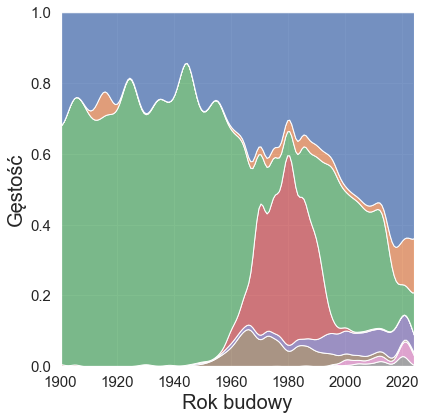

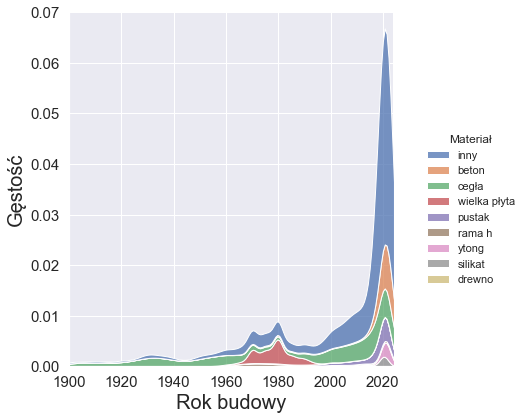

In [124]:
sns.displot(
    data=df_pd,
    x="Rok budowy", hue="Materiał",
    kind="kde", height=6,
    multiple="fill", clip=(0, None), legend=False) # palette="ch:rot=-.25,hue=1,light=.75"
plt.xlim(1900, 2024)
plt.ylabel("Gęstość")

sns.displot(
    data=df_pd,
    x="Rok budowy", hue="Materiał",
    kind="kde", height=6,
    multiple="stack", clip=(0, None))
plt.xlim(1900, 2024)
plt.ylabel("Gęstość")

##### Typ budynku a rok budowy

Text(13.735968750000005, 0.5, 'Gęstość')

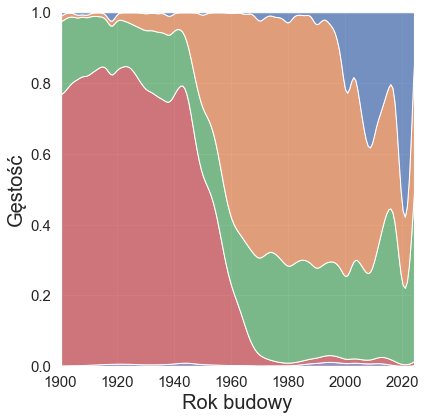

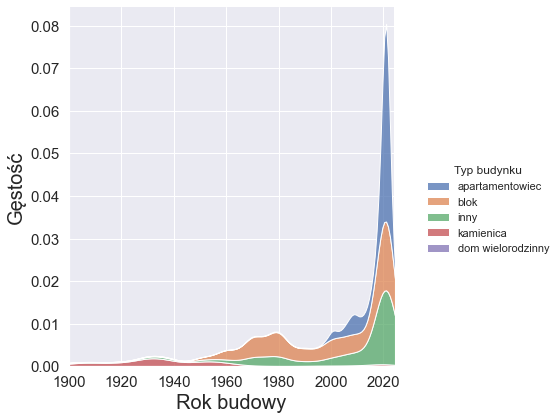

In [125]:
sns.displot(
    data=df_pd,
    x="Rok budowy", hue="Typ budynku",
    kind="kde", height=6,
    multiple="fill", clip=(0, None), legend=False)
plt.xlim(1900, 2024)
plt.ylabel("Gęstość")

sns.displot(
    data=df_pd,
    x="Rok budowy", hue="Typ budynku",
    kind="kde", height=6,
    multiple="stack", clip=(0, None))
plt.xlim(1900, 2024)
plt.ylabel("Gęstość")

##### Typ budynku a powierzchnia

Text(0, 0.5, 'Gęstość')

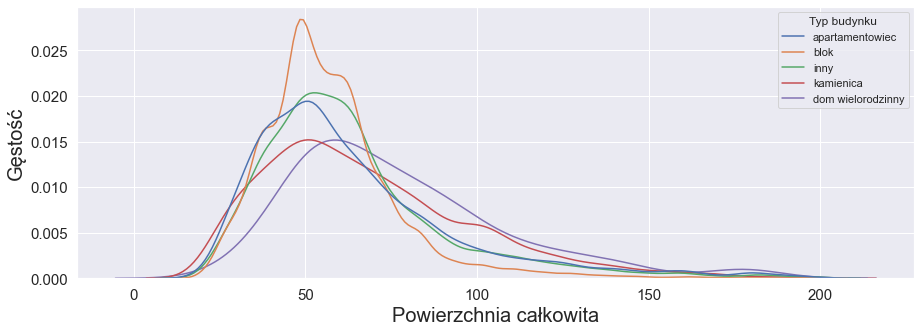

In [126]:
sns.set(rc={'figure.figsize':(15,5), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.kdeplot(
   data=df_pd, x="Powierzchnia całkowita", hue="Typ budynku",
   common_norm=False
)
plt.ylabel("Gęstość")

Text(0, 0.5, 'Gęstość')

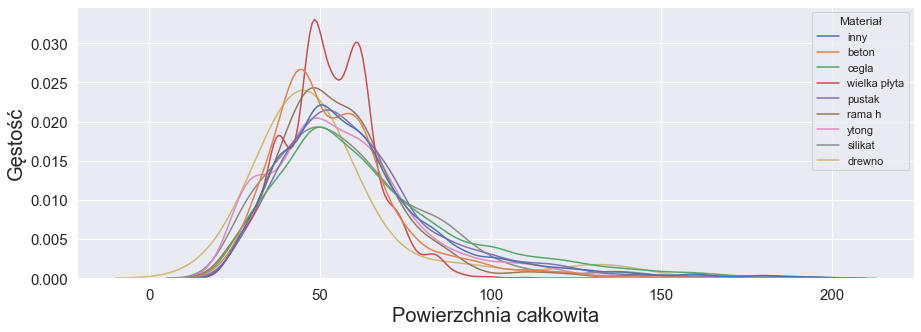

In [140]:
sns.set(rc={'figure.figsize':(15,5), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.kdeplot(
   data=df_pd, x="Powierzchnia całkowita", hue="Materiał",
   common_norm=False
)
plt.ylabel("Gęstość")

### Pozostałe

(20.0, 100.0)

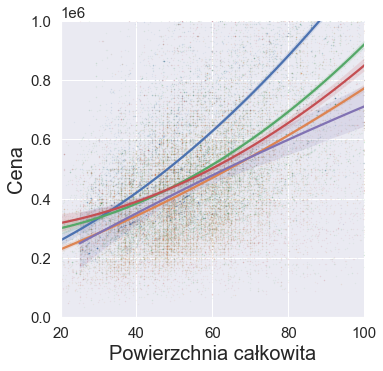

In [127]:
g = sns.lmplot(x='Powierzchnia całkowita',y='Cena', hue="Typ budynku", data=df_pd, order=2, legend=False,
               scatter_kws={"s": 0.1, "alpha": 0.1})
# for lh in g._legend.legendHandles: 
#     lh.set_alpha(1)
#     lh._sizes = [50] 
plt.ylim(0,1000000)
plt.xlim(20,100)

(20.0, 100.0)

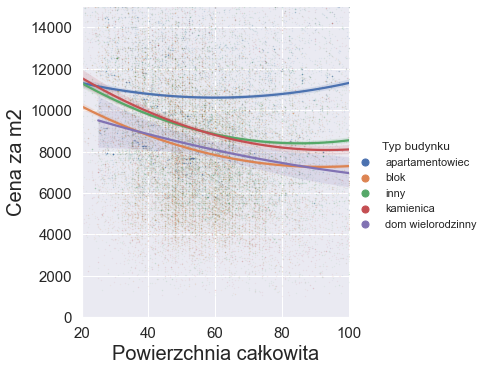

In [128]:
g = sns.lmplot(x='Powierzchnia całkowita',y='Cena za m2', hue="Typ budynku", data=df_pd, order=2,
               scatter_kws={"s": 0.1, "alpha": 0.1})
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
plt.ylim(0,15000)
plt.xlim(20,100)

(20.0, 100.0)

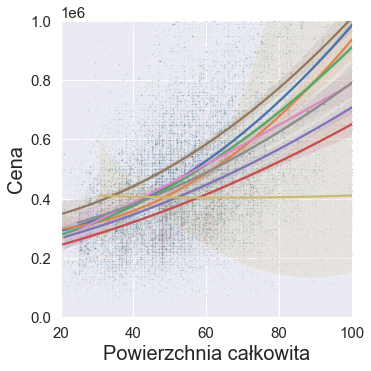

In [129]:
g = sns.lmplot(x='Powierzchnia całkowita',y='Cena', hue="Materiał", data=df_pd, order=2, legend=False,
               scatter_kws={"s": 0.1, "alpha": 0.1})
# for lh in g._legend.legendHandles: 
#     lh.set_alpha(1)
#     lh._sizes = [50] 
plt.ylim(0,1000000)
plt.xlim(20,100)

(20.0, 100.0)

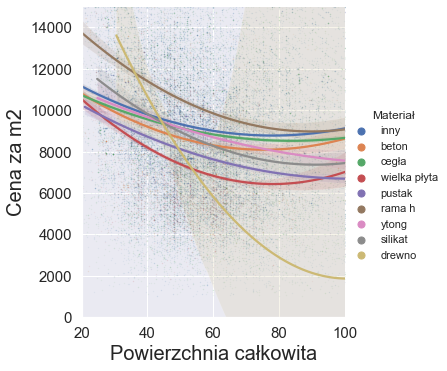

In [130]:
g = sns.lmplot(x='Powierzchnia całkowita',y='Cena za m2', hue="Materiał", data=df_pd, order=2,
               scatter_kws={"s": 0.1, "alpha": 0.1})
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
plt.ylim(0,15000)
plt.xlim(20,100)

In [131]:
windowSpec = Window.partitionBy("Liczba pokoi")

df_pd_tmp = df.select("Liczba pokoi", "Powierzchnia całkowita")\
.filter(df["Liczba pokoi"] < 6)\
.withColumn("powAvg", f.mean("Powierzchnia całkowita").over(windowSpec))\
.withColumn('Liczba pokoi', df['Liczba pokoi'].cast(IntegerType()))\
.orderBy("Liczba pokoi")\
.toPandas()

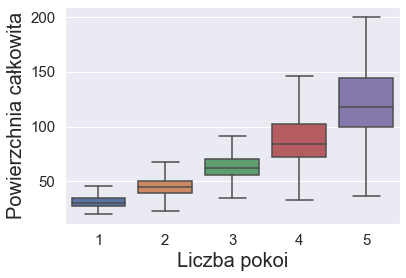

In [132]:
sns.set(rc={'figure.figsize':(6,4), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Liczba pokoi", y="Powierzchnia całkowita", data=df_pd_tmp, showfliers=False)

In [133]:
windowSpec = Window.partitionBy("Miejscowość")

df_pd_tmp = df.select("Powierzchnia całkowita", "Miejscowość")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 1000)\
.withColumn("powAvg", f.mean("Powierzchnia całkowita").over(windowSpec))\
.orderBy("powAvg", ascending=False)\
.toPandas()

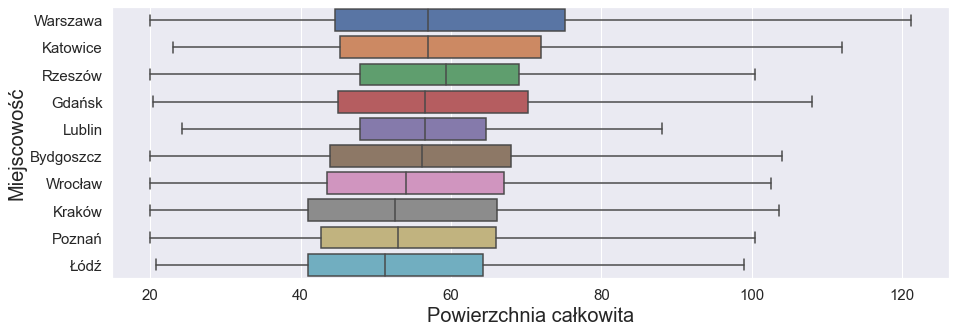

In [134]:
sns.set(rc={'figure.figsize':(15,5), "axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15})
sns.boxplot(x="Powierzchnia całkowita", y="Miejscowość", data=df_pd_tmp, showfliers=False)

In [138]:
df_pd_tmp = df.select("Rok budowy", "Miejscowość")\
.withColumn("miejscCount", f.count("Miejscowość").over(windowSpec))\
.filter(f.col("miejscCount") >= 1000)\
.toPandas()

Text(9.8864765625, 0.5, 'Gęstość')

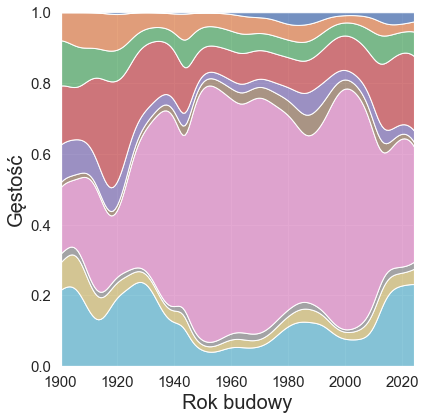

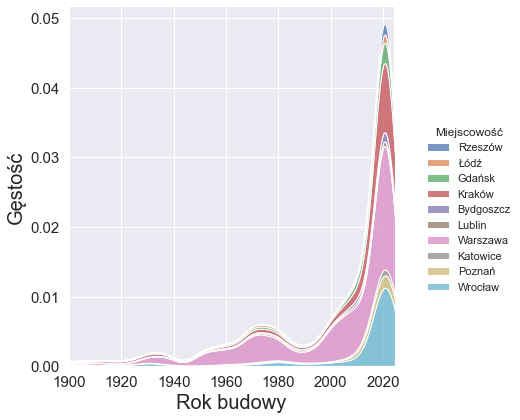

In [139]:
sns.displot(
    data=df_pd_tmp,
    x="Rok budowy", hue="Miejscowość",
    kind="kde", height=6,
    multiple="fill", clip=(0, None), legend=False)
plt.xlim(1900, 2024)
plt.ylabel("Gęstość")

sns.displot(
    data=df_pd_tmp,
    x="Rok budowy", hue="Miejscowość",
    kind="kde", height=6,
    multiple="stack", clip=(0, None))
plt.xlim(1900, 2024)
plt.ylabel("Gęstość")